# import

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import scipy.stats
from statsmodels.stats.proportion import proportions_ztest

import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.api import qqplot, add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

from sklearn.tree import export_graphviz
import graphviz
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.tree import plot_tree

matplotlib.rc('font', family = 'NanumGothic')
matplotlib.rc('axes', unicode_minus = False)

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error, r2_score
from statsmodels.tools.eval_measures import rmse
from sklearn.linear_model import Ridge, Lasso, ElasticNet

from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_squared_error, make_scorer
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

# 모델 성능 비교를 위한 성능 평가 출력 함수

In [2]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    adj_r2 = 1 - (1 - r2) * ((X_test.shape[0] - 1) / (X_test.shape[0] - X_test.shape[1] - 1))
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    cod = np.corrcoef(y_test, y_pred)[0, 1] ** 2
    print('Mean Absolute Error:', round(mae, 2))
    print('Mean Squared Error:', round(mse, 2))
    print('Root Mean Squared Error:', round(rmse, 2))
    print('R-squared:', round(r2, 2))
    print('Adjusted R-squared:', round(adj_r2, 2))
    print('Mean Absolute Percentage Error:', round(mape, 2), '%')
    print('Coefficient of Determination:', round(cod, 2))

# 데이터 불러오기, 전처리

## 데이터 기본 전처리

### 데이터 불러오기 및 그래프로 목표변수 확인

In [3]:
df_car = pd.read_csv("/home/piai/bigdata/실습화일/2. Big Data 분석/Car.csv")
df_car

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price
0,Maruti Wagon R LXI CNG,Mumbai,2682.68,2010,72000,CNG,Manual,First,26.6 kmpl,998 CC,58.16 bhp,5.0,NaN
1,Hyundai Creta 1.6 CRDi SX Option,Pune,19162.00,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN
2,Honda Jazz V,Chennai,6898.32,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh
3,Maruti Ertiga VDI,Chennai,9197.76,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,27194.71,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7248,Volkswagen Vento Diesel Trendline,Hyderabad,NaN,2011,89411,Diesel,Manual,First,20.54 kmpl,1598 CC,103.6 bhp,5.0,NaN
7249,Volkswagen Polo GT TSI,Mumbai,NaN,2015,59000,Petrol,Automatic,First,17.21 kmpl,1197 CC,103.6 bhp,5.0,NaN
7250,Nissan Micra Diesel XV,Kolkata,NaN,2012,28000,Diesel,Manual,First,23.08 kmpl,1461 CC,63.1 bhp,5.0,NaN
7251,Volkswagen Polo GT TSI,Pune,NaN,2013,52262,Petrol,Automatic,Third,17.2 kmpl,1197 CC,103.6 bhp,5.0,NaN


/home/piai/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Price', ylabel='Density'>

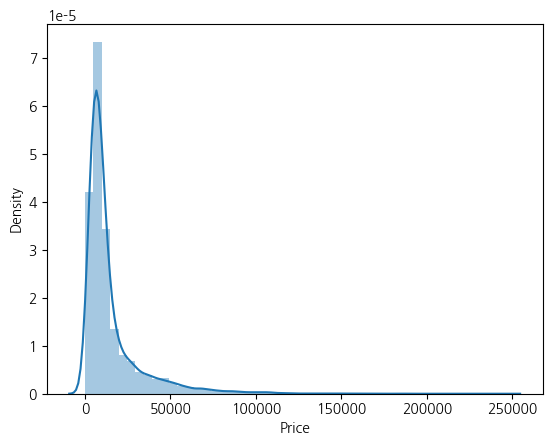

In [4]:
# 목표변수인 Price의 그래프를 그려보았다. log로 정규화가 필요하다는 것을 알 수 있다.

sns.distplot(df_car["Price"])

### 결측치 핸들링

In [5]:
# 결측치 확인

df_car.isnull().sum()

Name                    0
Location                0
Price                1053
Year                    0
Kilometers_Driven       0
Fuel_Type               0
Transmission            0
Owner_Type              0
Mileage                 2
Engine                 46
Power                  46
Seats                  53
New_Price            6247
dtype: int64

In [6]:
# 목표변수인 Price의 결측치는 다른것으로 대체하기 어렵다는 판단으로,
# 나중에 다시 대체하더라도 우선 제거하기로 결정했다.

df_drop1 = df_car["Price"].dropna()
df_car1 = df_car.iloc[df_drop1.index]

In [7]:
# 설명변수들의 단위 삭제, 데이터 타입 실수형으로 변경
# New_Price 의 경우는 결측치가 더 다수이기에 대체하지 않고 유지.
# 중간중간 결측치 타입의 문제, 불규칙한 문자 삽입 문제 이슈가 있었지만 해결

df_car1.loc[df_car1["Power"]=="null bhp",["Power"]] = None

df_car1['Mileage'] = df_car1['Mileage'].str.strip('kmpl')
df_car1['Engine'] = df_car1['Engine'].str.strip('CC')
df_car1['Power'] = df_car1['Power'].str.strip('bhp')
df_car1['New_Price'] = df_car1['New_Price'].str.strip('Lakh')

df_car1['Mileage'] = df_car1['Mileage'].astype(float)
df_car1['Engine'] = df_car1['Engine'].astype(float)
df_car1['Power'] = df_car1['Power'].astype(float)

df_car1['New_Price'] = df_car1['New_Price'].str.replace(' Cr', '')\
.apply(lambda x: float(x) if str(x).replace('.', '', 1).isdigit() else x)
df_car1['New_Price'] = df_car1['New_Price'].astype(float)

/tmp/ipykernel_2644/2775443794.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_car1['Mileage'] = df_car1['Mileage'].str.strip('kmpl')
/tmp/ipykernel_2644/2775443794.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_car1['Engine'] = df_car1['Engine'].str.strip('CC')
/tmp/ipykernel_2644/2775443794.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pa

In [8]:
df_car1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6200 entries, 0 to 7236
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               6200 non-null   object 
 1   Location           6200 non-null   object 
 2   Price              6200 non-null   float64
 3   Year               6200 non-null   int64  
 4   Kilometers_Driven  6200 non-null   int64  
 5   Fuel_Type          6200 non-null   object 
 6   Transmission       6200 non-null   object 
 7   Owner_Type         6200 non-null   object 
 8   Mileage            6198 non-null   float64
 9   Engine             6164 non-null   float64
 10  Power              6057 non-null   float64
 11  Seats              6158 non-null   float64
 12  New_Price          1005 non-null   float64
dtypes: float64(6), int64(2), object(5)
memory usage: 678.1+ KB


In [9]:
# 배기량 결측치를 평균으로 대체
# 엔진 최대 출력 결측치를 평균으로 대체
# 좌석 수 결측치를 평균으로 대체

df_car1["Engine"] = df_car1["Engine"].fillna(df_car1.mean()['Engine'])     
df_car1["Power"] = df_car1["Power"].fillna(df_car1.mean()['Power'])  
df_car1["Seats"] = df_car1["Seats"].fillna(df_car1.mean()['Seats'])  

/tmp/ipykernel_2644/3320777811.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_car1["Engine"] = df_car1["Engine"].fillna(df_car1.mean()['Engine'])
/tmp/ipykernel_2644/3320777811.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_car1["Engine"] = df_car1["Engine"].fillna(df_car1.mean()['Engine'])
/tmp/ipykernel_2644/3320777811.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_car1["Power"] = df_car

In [10]:
# 새 차 가격은 중고차 가격의 중요변수라 판단되지만 너무 결측치가 많아 제거         
df_car1 = df_car1.drop(labels="New_Price", axis=1)  

### 이상치 핸들링

In [11]:
# 이상치 탐지를 위해 임시로 연속형 컬럼만 모은 df_car_con 생성
df_car_con = df_car1[["Price","Year","Kilometers_Driven","Mileage","Engine","Power","Seats"]]

/home/piai/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/piai/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/piai/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/piai/an

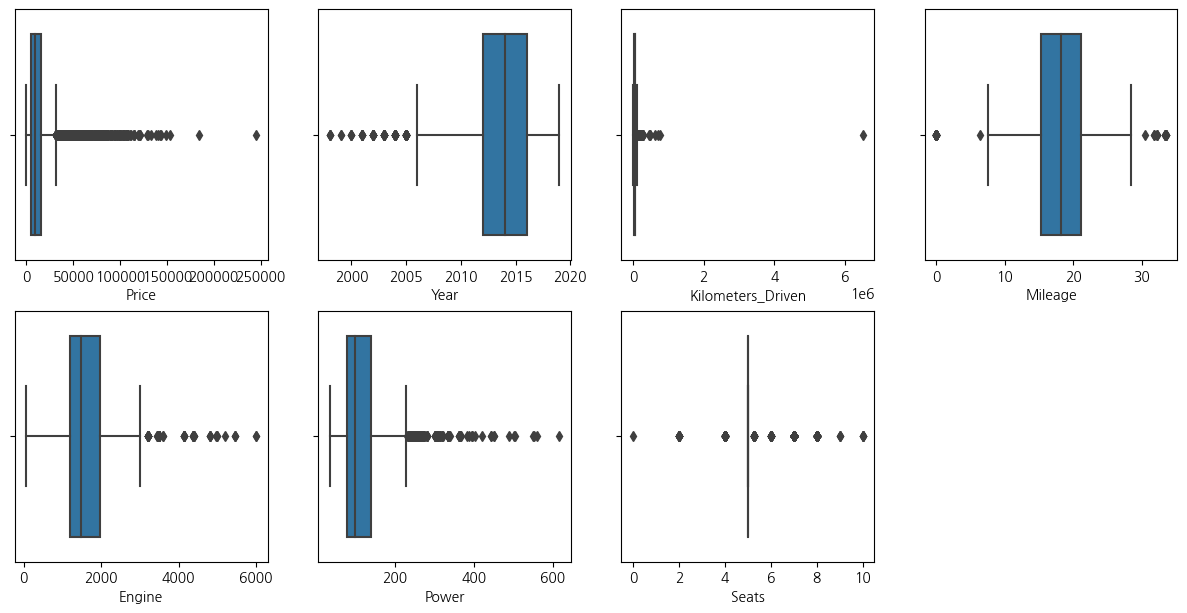

In [12]:
plt.figure(figsize=(15, 15))

for idx, col in enumerate(list(df_car_con)):
    plt.subplot(4, 4, idx+1)
    sns.boxplot(df_car_con[col])

In [13]:
# 너무나 키로수가 큰 이상치 제거
# 너무 작은 차 가격 제거
# 배기량 72.0cc는 너무 작아, 이상치인 듯 하여 제거
# 좌석수가 0인 이상치 제거
# 연비의 결측치 제거
# 마이리지 0 값 이상치와, 결측치 제거
df_car1 = df_car1[df_car1["Kilometers_Driven"]<6000000]
df_car1 = df_car1[df_car1["Price"]>8]
df_car1 = df_car1[df_car1["Engine"] != 72.0]   
df_car1 = df_car1[df_car1["Seats"] != 0.0]  
df_car1 = df_car1[df_car1["Mileage"] != 0.0] 
df_car1 = df_car1.dropna(subset=['Mileage'])  

In [14]:
# 가격의 정규분포화
df_car1["Log_Price"] = np.log1p(df_car1["Price"])

In [15]:
df_car1 = df_car1.reset_index(drop=True)      # index 초기화
df_car1.tail()

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Log_Price
6122,Datsun GO T Petrol,Chennai,8477.27,2016,36000,Petrol,Manual,First,19.83,1198.0,67.00,5.0,9.045262
6123,Tata Tiago 1.05 Revotorq XT Option,Pune,10822.70,2016,41413,Diesel,Manual,First,27.28,1047.0,69.00,5.0,9.289493
6124,Ford EcoSport 1.5 Petrol Ambiente,Kochi,13474.72,2017,39015,Petrol,Manual,First,17.00,1497.0,121.36,5.0,9.508645
6125,Jeep Compass 1.4 Sport,Mumbai,27838.55,2018,6000,Petrol,Manual,First,16.00,1368.0,160.00,5.0,10.234213
6126,Maruti Vitara Brezza ZDi,Kochi,16203.39,2017,21380,Diesel,Manual,First,24.30,1248.0,88.50,5.0,9.693037


In [124]:
df_car1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6127 entries, 0 to 6126
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Name                    6127 non-null   object 
 1   Location                6127 non-null   object 
 2   Price                   6127 non-null   float64
 3   Year                    6127 non-null   int64  
 4   Kilometers_Driven       6127 non-null   int64  
 5   Fuel_Type               6127 non-null   object 
 6   Transmission            6127 non-null   object 
 7   Owner_Type              6127 non-null   object 
 8   Mileage                 6127 non-null   float64
 9   Engine                  6127 non-null   float64
 10  Power                   6127 non-null   float64
 11  Seats                   6127 non-null   float64
 12  Log_Price               6127 non-null   float64
 13  Brand                   6127 non-null   object 
 14  Age                     6127 non-null   

## 파생변수 생성

In [16]:
# Name 에서 의미가 있는 Brand 만 추출하는 파생변수

df_car1['Brand'] = ''

for i in range(len(df_car1['Name'])):
    df_car1.at[i, 'Brand'] = df_car1.at[i, 'Name'].split()[0]

In [17]:
# 자동차 사용기한인 Age 파생변수 생성 (현재시점을 2022년으로)
df_car1["Age"] = 2022 - df_car1["Year"]

In [18]:
# 자동차의 성능 가성비 지표인 엔진 베기량cc당 파워 지표 생성
df_car1["Power_per_Engine"] = df_car1["Power"] / df_car1["Engine"]

In [19]:
# 연료 타입 데이터는 2021년 기준 연료 가격으로 바꾸면, 리터당 연료비 연속형 파생변수 생성 가능
# 거기서 멈추지 않고, 연비 / 리터당 연료비 연산으로 km / money 데이터 생성
# 같은 돈으로 얼마나 멀리 갈 수 있는지, 효율성 파생변수 생성

df_car1["Fuel_Type"].unique()

array(['CNG', 'Diesel', 'Petrol', 'LPG'], dtype=object)

In [20]:
# 인도 2021년 연료 가격 (인도루피 단위)
cng_price = 48.6
diesel_price = 73.2
petrol_price = 98.6
lpg_price = 39.6

# 연료 유형별 평균 가격 계산
fuel_prices = {
    'CNG': cng_price,
    'Diesel': diesel_price,
    'Petrol': petrol_price,
    'LPG': lpg_price
}

df_car1['Km_per_Rupee'] = df_car1['Mileage'] / df_car1['Fuel_Type'].map(fuel_prices)

In [21]:
# 판매가능 지역인 Location은 범주형 변수,
# 중고차 가격에 영향을 주는 것은 인구밀도 일 것이란 도메인 지식을 바탕으로 도시별 인구밀도 상수값으로 맵핑
# 인구밀도라는 파생변수 탄생

df_car1["Location"].unique()

array(['Mumbai', 'Pune', 'Chennai', 'Coimbatore', 'Hyderabad', 'Jaipur',
       'Kochi', 'Kolkata', 'Delhi', 'Bangalore', 'Ahmedabad'],
      dtype=object)

In [22]:
population_density = {
    'Mumbai': 20600,
    'Pune': 5741,
    'Chennai': 26284,
    'Coimbatore': 2176,
    'Hyderabad': 18440,
    'Jaipur': 3318,
    'Kochi': 2626,
    'Kolkata': 24344,
    'Delhi': 11297,
    'Bangalore': 4378,
    'Ahmedabad': 9835
}

df_car1["Population_Density"] = df_car1['Location'].map(population_density)

In [23]:
# 구매자 입장에서는 자동차 연식과 더불어 사용 거리가 사용감을 판단하는 지표라 판단
# 함께 고려하면 종합적인 사용감에 대한 고려가 될 거란 판단에, 곱하여 파생변수 제작

df_car1["KiloDriven_product_Age"] = df_car1["Kilometers_Driven"] * df_car1["Age"]

In [24]:
# 위에서 만든 Brand 파생변수를 브랜드별 평균 가격 데이터로 매핑하여 파생변수 Brand_Price 생성
df_car1["Brand"].unique()

array(['Maruti', 'Hyundai', 'Honda', 'Audi', 'Nissan', 'Toyota',
       'Volkswagen', 'Tata', 'Land', 'Mitsubishi', 'Renault',
       'Mercedes-Benz', 'BMW', 'Mahindra', 'Ford', 'Porsche', 'Datsun',
       'Jaguar', 'Volvo', 'Chevrolet', 'Skoda', 'Mini', 'Fiat', 'Jeep',
       'Ambassador', 'ISUZU', 'Force', 'Bentley', 'Lamborghini'],
      dtype=object)

In [25]:
Brand_Price = {
'Maruti': 80,'Hyundai': 150,'Honda': 200,'Audi': 500,
'Nissan': 120,'Toyota': 180,'Volkswagen': 120,'Tata': 65,
'Land': 500,'Mitsubishi': 200,'Renault': 100,'Mercedes-Benz': 500,
'BMW': 500,'Mahindra': 120,'Ford': 100,'Porsche': 1000,
'Datsun': 70,'Jaguar': 450,'Volvo': 400,'Chevrolet': 80,
'Skoda': 150,'Mini': 350,'Fiat': 80,'Jeep': 250,
'Smart': 100,'Ambassador': 50,'ISUZU': 250,'Force': 110,
'Bentley': 1500,'Lamborghini': 2000
}

df_car1["Brand_Price"] = df_car1['Brand'].map(Brand_Price)

In [26]:
# 수동 자동차와 자동 자동차 가격의 평균 비율을 적용하여, Type_Price 파생변수 생성

Type_Price = {'Manual': 1.00, 'Automatic': 1.35}
df_car1["Type_Price"] = df_car1['Transmission'].map(Type_Price)

In [27]:
# 몇 번째 차주인지를 나타내는 owner_type 을 대응하는 숫자로 매핑한 파생변수 Users_Num 생성
df_car1["Owner_Type"].unique()

array(['First', 'Second', 'Fourth & Above', 'Third'], dtype=object)

In [28]:
users_num = {'First':1, 'Second':2, 'Fourth & Above':4, 'Third':3}
df_car1["Users_Num"] = df_car1['Owner_Type'].map(users_num)

In [29]:
# 배기량을 기준으로 차량의 크기를 구분하는 범주형 컬럼 Segment 생성

# Define the thresholds for each category
small = 1000
semi_medium = 1500
medium = 2000
large = 2500

# Create a new column based on the engine displacement
def categorize_displacement(displacement):
    if displacement <= small:
        return "Small"
    elif displacement <= semi_medium:
        return "Semi-Medium"
    elif displacement <= medium:
        return "Medium"
    elif displacement <= large:
        return "Large"
    else:
        return "Extra Large"

df_car1['Segment'] = df_car1['Engine'].apply(categorize_displacement)

In [30]:
# 전처리 최종확인
df_car1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6127 entries, 0 to 6126
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Name                    6127 non-null   object 
 1   Location                6127 non-null   object 
 2   Price                   6127 non-null   float64
 3   Year                    6127 non-null   int64  
 4   Kilometers_Driven       6127 non-null   int64  
 5   Fuel_Type               6127 non-null   object 
 6   Transmission            6127 non-null   object 
 7   Owner_Type              6127 non-null   object 
 8   Mileage                 6127 non-null   float64
 9   Engine                  6127 non-null   float64
 10  Power                   6127 non-null   float64
 11  Seats                   6127 non-null   float64
 12  Log_Price               6127 non-null   float64
 13  Brand                   6127 non-null   object 
 14  Age                     6127 non-null   

## 연속형 컬럼만 모은 데이터 프레임 df_con 생성
(추가로 scale 변환도 진행)

In [31]:
# 연속형 변수만 모은 데이터 프레임 df_con 생성

df_con = df_car1[['Log_Price','Kilometers_Driven','Mileage','Engine','Power','Seats','Age','Power_per_Engine',
                  'Km_per_Rupee','Population_Density','KiloDriven_product_Age','Brand_Price','Type_Price','Users_Num']]
df_con.head()

,Log_Price,Kilometers_Driven,Mileage,Engine,Power,Seats,Age,Power_per_Engine,Km_per_Rupee,Population_Density,KiloDriven_product_Age,Brand_Price,Type_Price,Users_Num
0,7.894944,72000,26.60,998.0,58.16,5.0,12,0.058277,0.547325,20600,864000,80,1.00,1
1,9.860737,41000,19.67,1582.0,126.20,5.0,7,0.079772,0.268716,5741,287000,150,1.00,1
2,8.839178,46000,18.20,1199.0,88.70,5.0,11,0.073978,0.184584,26284,506000,200,1.00,1
3,9.126824,87000,20.77,1248.0,88.76,7.0,10,0.071122,0.283743,26284,870000,80,1.00,1
4,10.210815,40670,15.20,1968.0,140.80,5.0,9,0.071545,0.207650,2176,366030,500,1.35,2


In [32]:
df_con.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6127 entries, 0 to 6126
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Log_Price               6127 non-null   float64
 1   Kilometers_Driven       6127 non-null   int64  
 2   Mileage                 6127 non-null   float64
 3   Engine                  6127 non-null   float64
 4   Power                   6127 non-null   float64
 5   Seats                   6127 non-null   float64
 6   Age                     6127 non-null   int64  
 7   Power_per_Engine        6127 non-null   float64
 8   Km_per_Rupee            6127 non-null   float64
 9   Population_Density      6127 non-null   int64  
 10  KiloDriven_product_Age  6127 non-null   int64  
 11  Brand_Price             6127 non-null   int64  
 12  Type_Price              6127 non-null   float64
 13  Users_Num               6127 non-null   int64  
dtypes: float64(8), int64(6)
memory usage: 67

### df_con의 scale 변환

In [33]:
cols = df_con.columns
scaler = StandardScaler()
nd_scaled = scaler.fit_transform(df_con)
df_con = pd.DataFrame(nd_scaled, columns=cols)

### df_con의 목적별 train, test 데이터 분리

In [34]:
# 다중회귀 분석을 위한 train, test 데이터 분리
df_con_train, df_con_test = train_test_split(df_con, test_size=0.4, random_state=1234)
print(df_con_train.shape)
print(df_con_test.shape)

(3676, 14)
(2451, 14)


In [35]:
# train_x, test_x, train_y, test_y 데이터 분리
df_con_x = df_con.drop("Log_Price", axis = 1, inplace = False)
df_con_y = df_con["Log_Price"]

df_con_train_x, df_con_test_x, df_con_train_y, df_con_test_y = train_test_split(df_con_x, df_con_y, test_size=0.4)

## 필요없는 변수 제거하고, 연속형 범주형 모두 포함하는 데이터 프레임 df 생성 후
## 더미화로 인코딩한 df_dummy 생성
(1 대 1로 원핫 인코딩한 파생변수는 본래의 범주형 컬럼을 포함시킨다.)

In [36]:
df = df_car1[['Log_Price','Location','Kilometers_Driven','Fuel_Type','Transmission','Owner_Type','Mileage',
              'Engine','Power','Seats','Brand','Age','Power_per_Engine','Km_per_Rupee','KiloDriven_product_Age','Segment']]

In [37]:
# 범주형 변수를 회귀 모델에 적용하기 위한 더미화
df_dummy = pd.get_dummies(df, drop_first=True)
df_dummy.head()

,Log_Price,Kilometers_Driven,Mileage,Engine,Power,Seats,Age,Power_per_Engine,Km_per_Rupee,KiloDriven_product_Age,...,Brand_Renault,Brand_Skoda,Brand_Tata,Brand_Toyota,Brand_Volkswagen,Brand_Volvo,Segment_Large,Segment_Medium,Segment_Semi-Medium,Segment_Small
0,7.894944,72000,26.60,998.0,58.16,5.0,12,0.058277,0.547325,864000,...,0,0,0,0,0,0,0,0,0,1
1,9.860737,41000,19.67,1582.0,126.20,5.0,7,0.079772,0.268716,287000,...,0,0,0,0,0,0,0,1,0,0
2,8.839178,46000,18.20,1199.0,88.70,5.0,11,0.073978,0.184584,506000,...,0,0,0,0,0,0,0,0,1,0
3,9.126824,87000,20.77,1248.0,88.76,7.0,10,0.071122,0.283743,870000,...,0,0,0,0,0,0,0,0,1,0
4,10.210815,40670,15.20,1968.0,140.80,5.0,9,0.071545,0.207650,366030,...,0,0,0,0,0,0,0,1,0,0


In [38]:
df_dummy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6127 entries, 0 to 6126
Data columns (total 59 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Log_Price                  6127 non-null   float64
 1   Kilometers_Driven          6127 non-null   int64  
 2   Mileage                    6127 non-null   float64
 3   Engine                     6127 non-null   float64
 4   Power                      6127 non-null   float64
 5   Seats                      6127 non-null   float64
 6   Age                        6127 non-null   int64  
 7   Power_per_Engine           6127 non-null   float64
 8   Km_per_Rupee               6127 non-null   float64
 9   KiloDriven_product_Age     6127 non-null   int64  
 10  Location_Bangalore         6127 non-null   uint8  
 11  Location_Chennai           6127 non-null   uint8  
 12  Location_Coimbatore        6127 non-null   uint8  
 13  Location_Delhi             6127 non-null   uint8

In [39]:
# train_x, test_x, train_y, test_y 데이터 분리
df_dummy_x = df_con.drop("Log_Price", axis = 1, inplace = False)
df_dummy_y = df_con["Log_Price"]

df_dummy_train_x, df_dummy_test_x, df_dummy_train_y, df_dummy_test_y = train_test_split(df_dummy_x, df_dummy_y, test_size=0.4)

# 탐색적 데이터 분석 EDA

## 연속형 only 데이터프레임, df_con에 대한 탐색적 분석

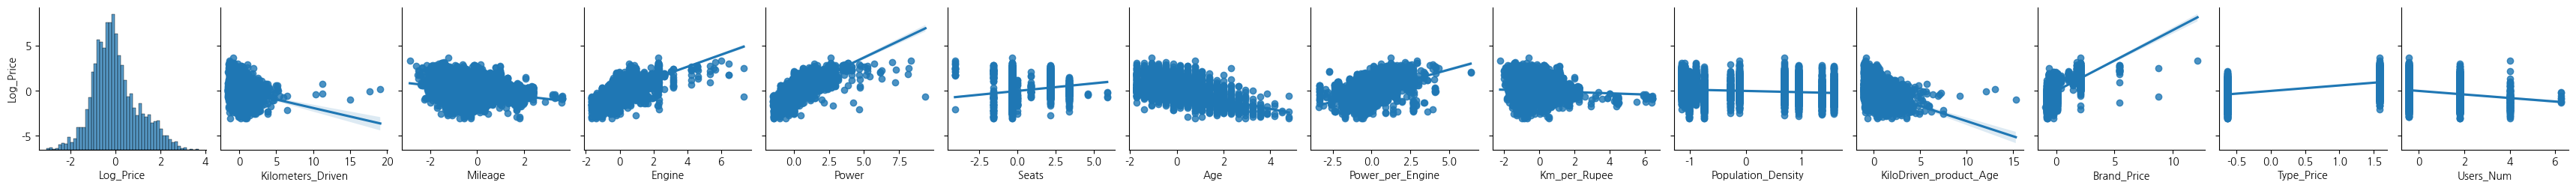

In [36]:
# 데이터의 상관관계를 볼 수 있도록 시각화
sns.pairplot(df_con, y_vars="Log_Price", x_vars=[i for i in df_con.columns], kind="reg")
plt.show()

In [37]:
# 상관계수 출력
df_con.corr().round(3)

,Log_Price,Kilometers_Driven,Mileage,Engine,Power,Seats,Age,Power_per_Engine,Km_per_Rupee,Population_Density,KiloDriven_product_Age,Brand_Price,Type_Price,Users_Num
Log_Price,1.000,-0.189,-0.297,0.671,0.742,0.169,-0.498,0.473,-0.066,-0.142,-0.336,0.675,0.610,-0.197
Kilometers_Driven,-0.189,1.000,-0.142,0.158,0.004,0.211,0.452,-0.212,0.002,0.031,0.899,-0.059,-0.107,0.218
Mileage,-0.297,-0.142,1.000,-0.646,-0.550,-0.350,-0.298,-0.154,0.844,0.008,-0.236,-0.381,-0.359,-0.152
Engine,0.671,0.158,-0.646,1.000,0.861,0.400,0.062,0.182,-0.321,-0.021,0.137,0.616,0.494,0.055
Power,0.742,0.004,-0.550,0.861,1.000,0.100,-0.009,0.628,-0.305,-0.039,-0.007,0.779,0.635,0.027
Seats,0.169,0.211,-0.350,0.400,0.100,1.000,-0.012,-0.319,-0.157,-0.005,0.151,-0.104,-0.070,0.011
Age,-0.498,0.452,-0.298,0.062,-0.009,-0.012,1.000,-0.130,-0.254,0.190,0.722,0.003,-0.094,0.393
Power_per_Engine,0.473,-0.212,-0.154,0.182,0.628,-0.319,-0.130,1.000,-0.164,-0.045,-0.209,0.560,0.502,-0.039
Km_per_Rupee,-0.066,0.002,0.844,-0.321,-0.305,-0.157,-0.254,-0.164,1.000,0.011,-0.124,-0.201,-0.228,-0.125
Population_Density,-0.142,0.031,0.008,-0.021,-0.039,-0.005,0.190,-0.045,0.011,1.000,0.090,-0.044,-0.045,-0.007


<AxesSubplot:>

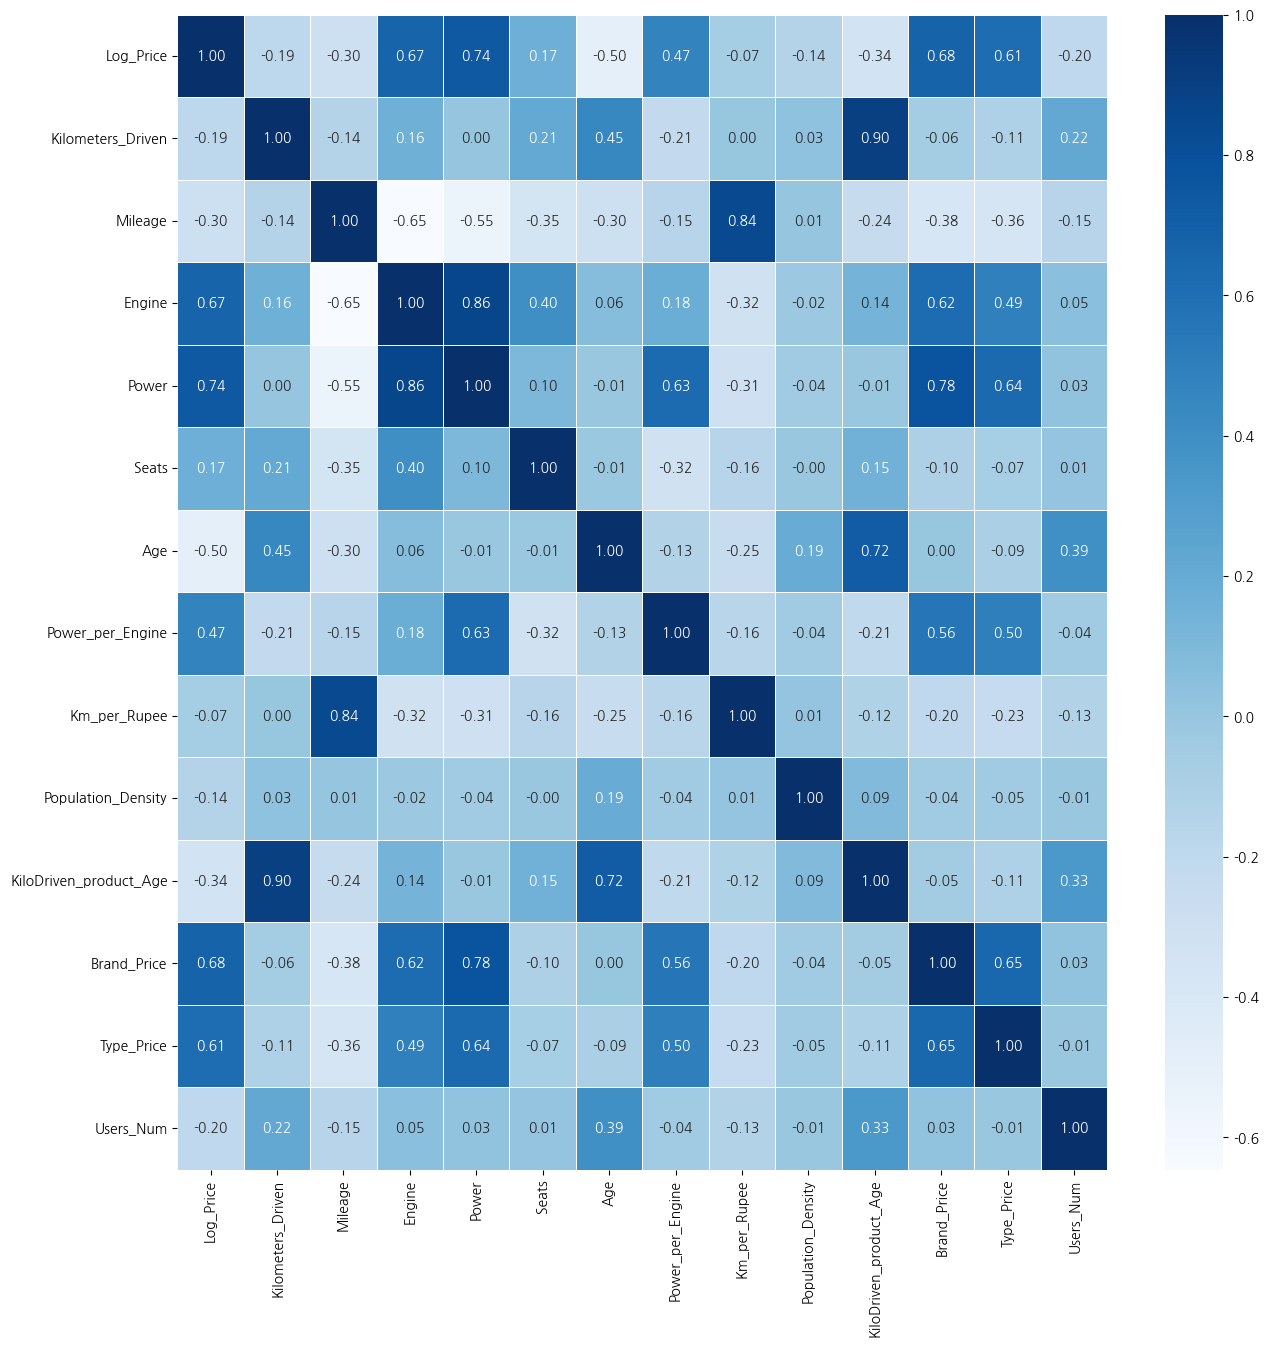

In [38]:
# 상관계수 시각화
plt.figure(figsize=(15,15))
sns.heatmap(data = df_con.corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap='Blues')

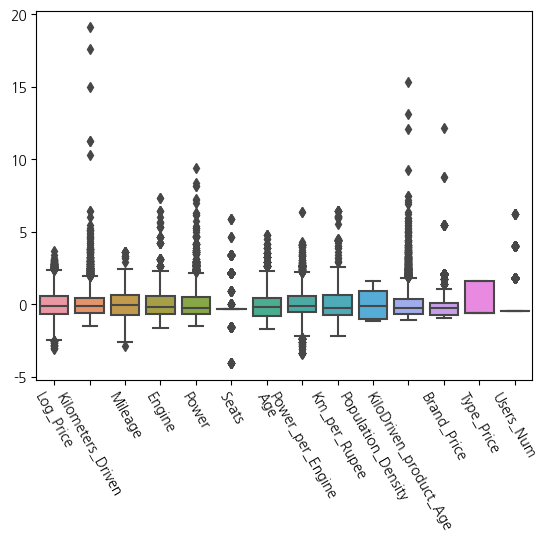

In [39]:
# 이상치 재확인
sns.boxplot(data=df_con)
plt.xticks(rotation=-60)
plt.show()

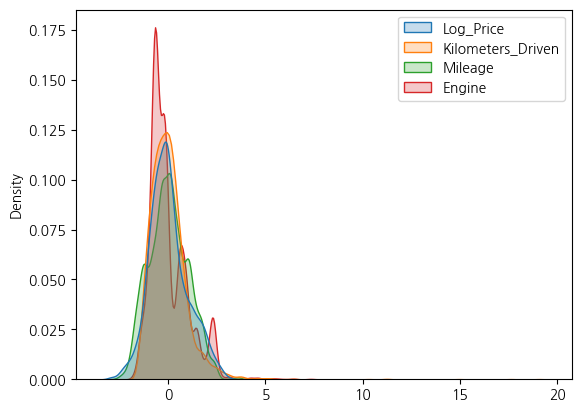

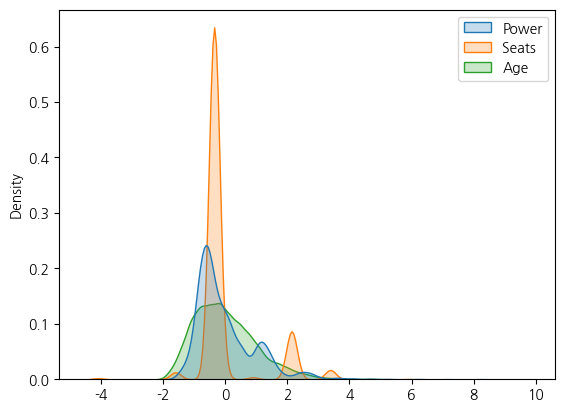

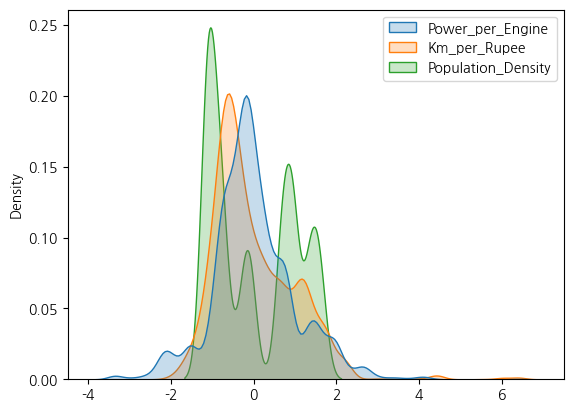

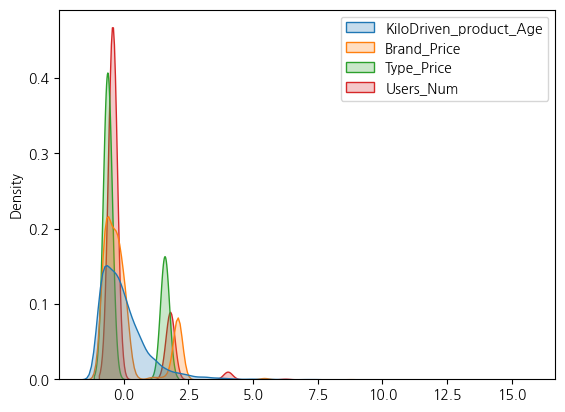

In [40]:
# 분포에 대한 밀도 시각화
sns.kdeplot(data=df_con.iloc[:,:4], shade=True)
plt.show()
sns.kdeplot(data=df_con.iloc[:,4:7], shade=True)
plt.show()
sns.kdeplot(data=df_con.iloc[:,7:10], shade=True)
plt.show()
sns.kdeplot(data=df_con.iloc[:,10:14], shade=True)
plt.show()

## 연속형, 범주형 모두 있는 'df'에 대한 탐색적분석

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6127 entries, 0 to 6126
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Log_Price               6127 non-null   float64
 1   Location                6127 non-null   object 
 2   Kilometers_Driven       6127 non-null   int64  
 3   Fuel_Type               6127 non-null   object 
 4   Transmission            6127 non-null   object 
 5   Owner_Type              6127 non-null   object 
 6   Mileage                 6127 non-null   float64
 7   Engine                  6127 non-null   float64
 8   Power                   6127 non-null   float64
 9   Seats                   6127 non-null   float64
 10  Brand                   6127 non-null   object 
 11  Age                     6127 non-null   int64  
 12  Power_per_Engine        6127 non-null   float64
 13  Km_per_Rupee            6127 non-null   float64
 14  KiloDriven_product_Age  6127 non-null   

### 범주형 변수들의 가격에 대한 barplot

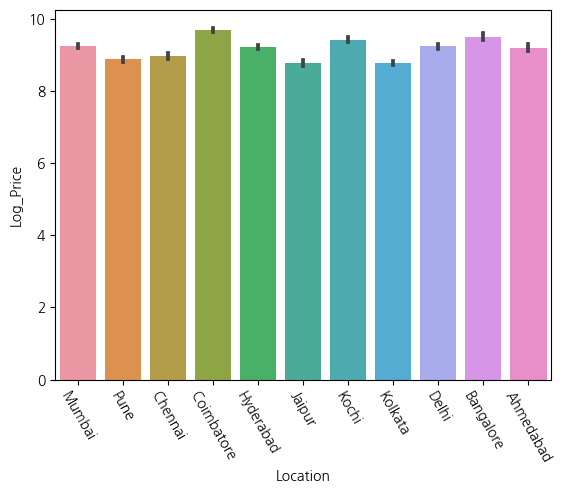

In [66]:
sns.barplot(data=df, x='Location', y='Log_Price')
plt.xticks(rotation=-60)
plt.show()

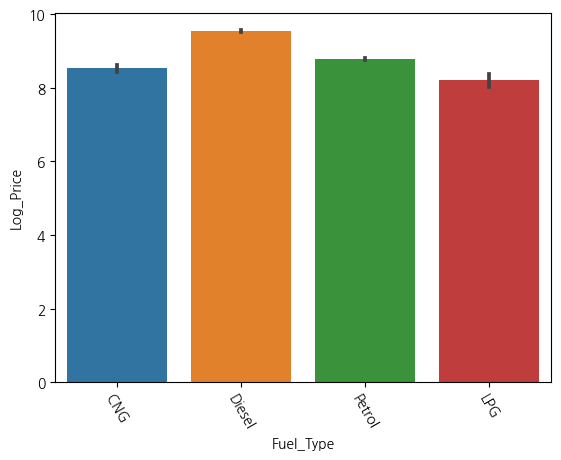

In [59]:
sns.barplot(data=df, x='Fuel_Type', y='Log_Price')
plt.xticks(rotation=-60)
plt.show()

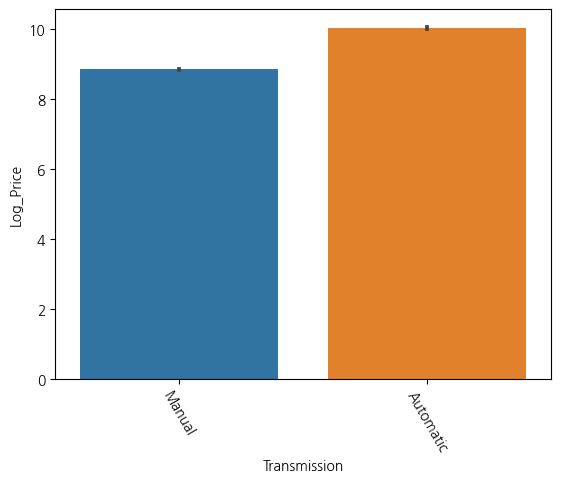

In [57]:
sns.barplot(data=df, x='Transmission', y='Log_Price')
plt.xticks(rotation=-60)
plt.show()

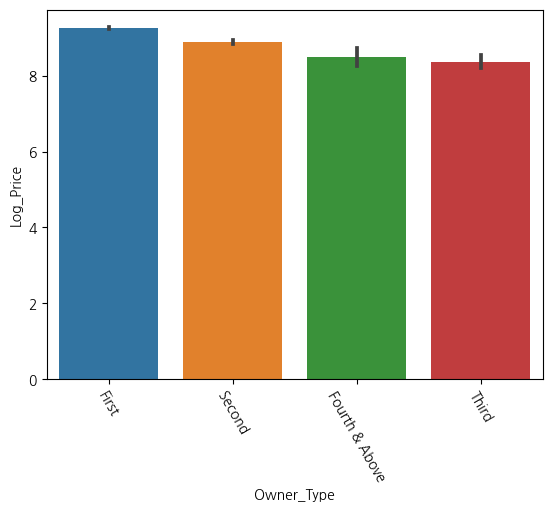

In [58]:
sns.barplot(data=df, x='Owner_Type', y='Log_Price')
plt.xticks(rotation=-60)
plt.show()

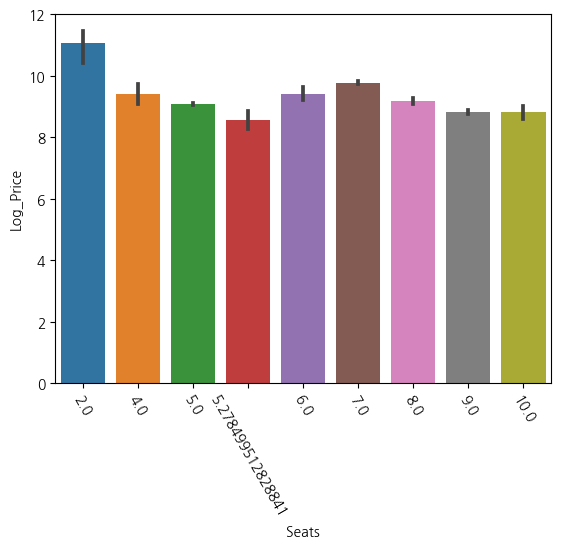

In [95]:
sns.barplot(data=df, x='Seats', y='Log_Price')
plt.xticks(rotation=-60)
plt.show()

In [121]:
# 좌석수가 5.27... 으로 표현된 이상치가 보여서 슬라이싱으로 관찰하려 했으나 출력이 안된다.
# 찾지 못하고 있거나, 이상치가 없는데 그래프 출력에서 오류가 발생했거나 라고 생각된다.
df[(df["Seats"]<5) & (df["Seats"]>6)]

,Log_Price,Location,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Brand,Age,Power_per_Engine,Km_per_Rupee,KiloDriven_product_Age,Segment


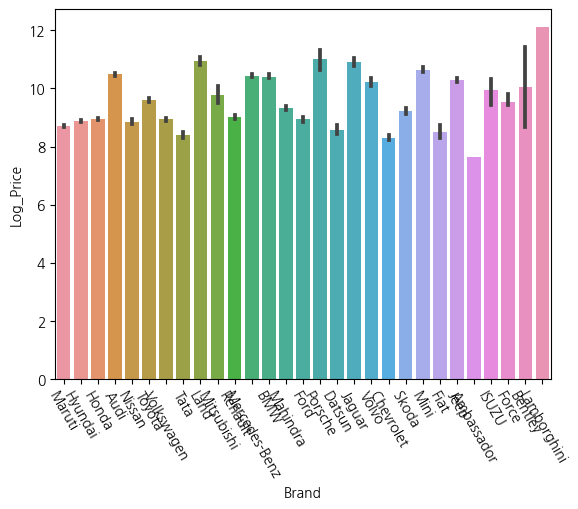

In [96]:
sns.barplot(data=df, x='Brand', y='Log_Price')
plt.xticks(rotation=-60)
plt.show()

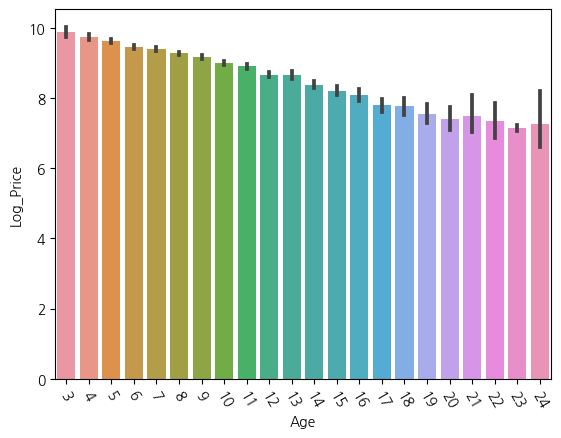

In [120]:
sns.barplot(data=df, x='Age', y='Log_Price')
plt.xticks(rotation=-60)
plt.show()

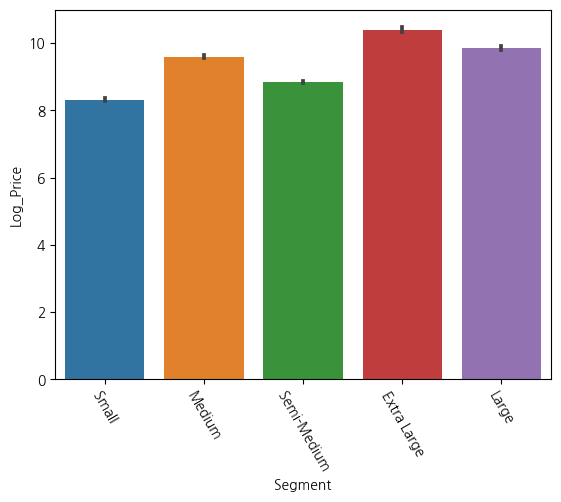

In [56]:
sns.barplot(data=df, x='Segment', y='Log_Price')
plt.xticks(rotation=-60)
plt.show()

### pie chart

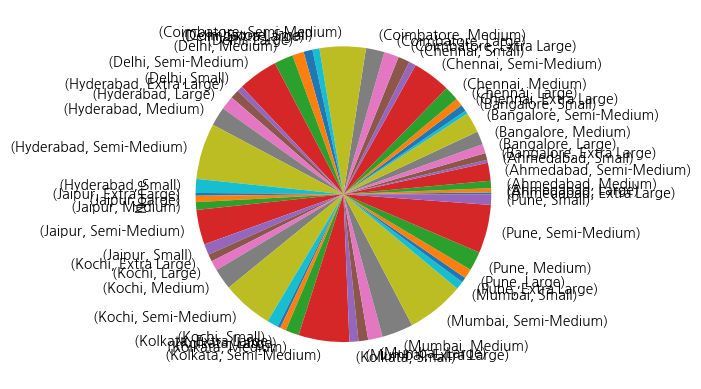

In [122]:
# 판매위치와 차 사이즈 유형에 대하여 어떠한 관계가 있을거란 추측으로 출력해보았다.
df_count = df.groupby(["Location","Segment"]).size()
df_count.plot.pie()
plt.show()

별다른 관계가 보이지는 않는다.

# 다중 회귀 분석 about 'df_con'
다중 회귀 분석을 진행하며 변수들간 다중공선성, 등분산성, 정규성, 독립성 또한 검증하도록 하겠다.

## 다중 회귀 모델 출력, 다중공선성 해결

In [133]:
# 다중 회귀 모델 출력

reg_model = smf.ols(formula = "Log_Price ~ Kilometers_Driven + Mileage + Engine + Power\
+ Seats + Age + Power_per_Engine + Km_per_Rupee + Population_Density + KiloDriven_product_Age\
+ Brand_Price + Type_Price +Users_Num", data=df_con_train)

reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:              Log_Price   R-squared:                       0.871
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     1904.
Date:                Sun, 05 Mar 2023   Prob (F-statistic):               0.00
Time:                        19:29:30   Log-Likelihood:                -1458.9
No. Observations:                3676   AIC:                             2946.
Df Residuals:                    3662   BIC:                             3033.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0

In [134]:
# p-value > 0.05 인 KiloDriven_product_Age, Kilometers_Driven 제거

reg_model = smf.ols(formula = "Log_Price ~ Mileage + Engine + Power\
+ Seats + Age + Power_per_Engine + Km_per_Rupee + Population_Density\
+ Brand_Price + Type_Price +Users_Num", data=df_con_train)

reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:              Log_Price   R-squared:                       0.871
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     2249.
Date:                Sun, 05 Mar 2023   Prob (F-statistic):               0.00
Time:                        19:29:35   Log-Likelihood:                -1460.2
No. Observations:                3676   AIC:                             2944.
Df Residuals:                    3664   BIC:                             3019.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.0014      0

In [135]:
# VIF 출력

df_con_train_x = df_con_train.drop(["Log_Price","KiloDriven_product_Age","Kilometers_Driven"], axis =1)
df_con_train_x_const = add_constant(df_con_train_x)

df_vif = pd.DataFrame()
df_vif["variable"] = df_con_train_x_const.columns
df_vif["VIF"] = [variance_inflation_factor(df_con_train_x_const, i) for i in range(df_con_train_x_const.shape[1])]
df_vif.sort_values("VIF", ascending = False).round(2)

,variable,VIF
3,Power,41.32
2,Engine,30.60
6,Power_per_Engine,9.89
1,Mileage,9.03
7,Km_per_Rupee,5.35
9,Brand_Price,3.02
10,Type_Price,1.97
4,Seats,1.93
5,Age,1.54
11,Users_Num,1.22


In [140]:
# VIF > 10 인 Power 제거

df_con_train_x = df_con_train.drop(["Log_Price","Power","KiloDriven_product_Age","Kilometers_Driven"], axis =1)
df_con_train_x_const = add_constant(df_con_train_x)

df_vif = pd.DataFrame()
df_vif["variable"] = df_con_train_x_const.columns
df_vif["VIF"] = [variance_inflation_factor(df_con_train_x_const, i) for i in range(df_con_train_x_const.shape[1])]
df_vif.sort_values("VIF", ascending = False).round(2)

,variable,VIF
1,Mileage,8.93
6,Km_per_Rupee,5.34
2,Engine,3.66
8,Brand_Price,2.97
9,Type_Price,1.97
5,Power_per_Engine,1.84
3,Seats,1.76
4,Age,1.53
10,Users_Num,1.22
7,Population_Density,1.06


In [145]:
# p-value, VIF 조건 모두 만족한 다중 회귀 모델 출력

reg_model = smf.ols(formula = "Log_Price ~ Mileage + Engine\
+ Seats + Age + Power_per_Engine + Km_per_Rupee + Population_Density\
+ Brand_Price + Type_Price +Users_Num", data=df_con_train)

reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:              Log_Price   R-squared:                       0.866
Model:                            OLS   Adj. R-squared:                  0.866
Method:                 Least Squares   F-statistic:                     2370.
Date:                Sun, 05 Mar 2023   Prob (F-statistic):               0.00
Time:                        19:36:02   Log-Likelihood:                -1529.0
No. Observations:                3676   AIC:                             3080.
Df Residuals:                    3665   BIC:                             3148.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.0004      0

## 등분산성, 정규성, 독립성 검정

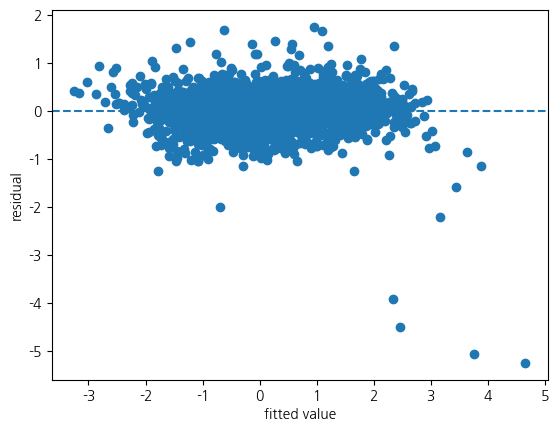

In [142]:
# 등분산성 검정
# 0.0을 기준으로 점점 더 퍼지는 등분산의 모양임이 보인다.
plt.scatter(reg_result.fittedvalues, reg_result.resid)
plt.xlabel("fitted value")
plt.ylabel("residual")
plt.axhline(y=0, linestyle="--")
plt.show()

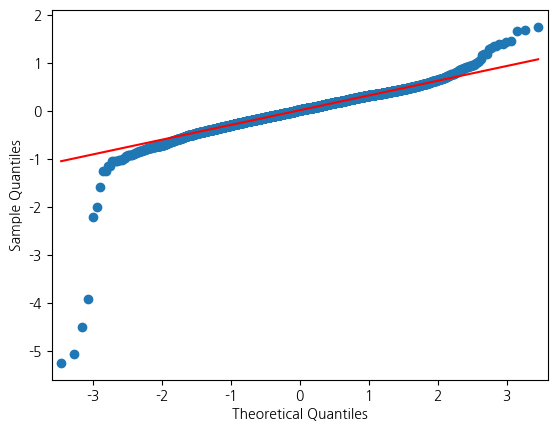

In [143]:
# 정규성 검정
# 빨강색으로 그려진 1차 linear라인 주변으로 형성되어있으므로 정규성을 띈다 할 수 있다.
qqplot(reg_result.resid, line="q")
plt.show()

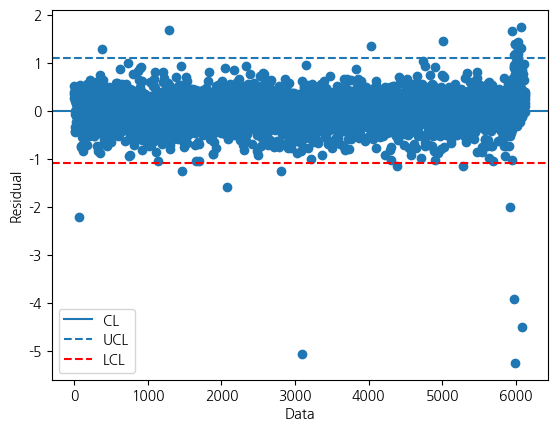

In [144]:
# 독립성 검정
# 잔차값의 크기가 CL과 LCL라인을 벗어나지 않고 표현되었다. 따라서 독립성을 띈다 볼 수 있다.
plt.scatter(df_con_train.index, reg_result.resid)
plt.xlabel("Data")
plt.ylabel("Residual")
plt.axhline(y=0, linestyle="-", label="CL")
plt.axhline(y=3*np.std(reg_result.resid), linestyle="--", label="UCL")
plt.axhline(y=-3*np.std(reg_result.resid), linestyle="dashed", color="red", label="LCL")
plt.legend()
plt.show()

## 다중 회귀 모델 결과 출력 및 분석

In [162]:
train_pred = reg_result.predict(df_con_train)
test_pred = reg_result.predict(df_con_test)
print("train data 결정계수: ", r2_score(df_con_train['Log_Price'], train_pred))
print("test data 결정계수: ", r2_score(df_con_test['Log_Price'], test_pred))

train data 결정계수:  0.8660837496109005
test data 결정계수:  0.8792295938399723


                        Coef
Mileage            -0.189365
Engine              0.359338
Seats               0.074720
Age                -0.469330
Power_per_Engine    0.164599
Km_per_Rupee        0.209253
Population_Density -0.017401
Brand_Price         0.258693
Type_Price          0.116705
Users_Num          -0.037061


<AxesSubplot:>

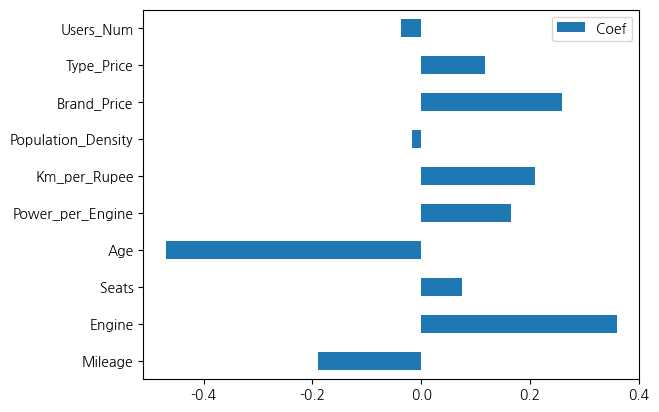

In [163]:
df_reg_coef = pd.DataFrame({"Coef": reg_result.params.values[1:]},
                           index = ["Mileage", "Engine", "Seats", "Age", "Power_per_Engine", "Km_per_Rupee",
                                    "Population_Density", "Brand_Price", "Type_Price", "Users_Num"])
print(df_reg_coef)
df_reg_coef.plot.barh(y="Coef")

- Age(연식)의 증가가 중고차 가격의 큰 마이너스 요인임을 알 수 있다.
- Engine(배기량)은 차량 성능의 중요 지표이다. 그렇기에 높을 수록 가격이 높아지는 큰 플러스 요인이다.
- Brand_Price(브랜드당 평균가격): 브랜드 이름은 당연히 구매할 때 많이 고려되는 지표이다. 비싼 자동차는 부의 상징 중 하나이기 때문에 브랜드당 평균 가격이 높을 수록 중고차도 비싸게 판매된다.
- Km_per_Rupee(연료비에 대하여 같은 돈에 얼마나 먼 거리를 주행 할 수 있는지)는 차량의 주행 가성비에 대한 지표이다. 성능의 중요 지표 중 하나이기에 중고차 가격의 주요 상승 원인일 것이다.
- 그 밖에 차량의 배기량당 파워(같은 배기량이더라도 얼마나 좋은 성능을 뽑아내는지) 또한 중고차 가격의 상승 요인임을 알 수 있다.

In [164]:
ridge = Ridge(random_state=1234, alpha =1)
ridge.fit(df_con_train_x, df_con_train_y)

train_pred = ridge.predict(df_con_train_x)
test_pred = ridge.predict(df_con_test_x)
print(r2_score(df_con_train_y, train_pred))
print(r2_score(df_con_test_y, test_pred))

0.8786598414720325
0.869747026214291


In [165]:
lasso = Lasso(random_state=1234, alpha=1)
lasso.fit(df_con_train_x, df_con_train_y)

train_pred = lasso.predict(df_con_train_x)
test_pred = lasso.predict(df_con_test_x)
print(r2_score(df_con_train_y, train_pred))
print(r2_score(df_con_test_y, test_pred))

0.0
-0.00016744363952780894


In [166]:
elastic = ElasticNet(random_state=1234, alpha=1, l1_ratio=0.5)
elastic.fit(df_con_train_x, df_con_train_y)

train_pred = elastic.predict(df_con_train_x)
test_pred = elastic.predict(df_con_test_x)
print(r2_score(df_con_train_y, train_pred))
print(r2_score(df_con_test_y, test_pred))

0.2481216278893652
0.24405550522160113


- 규제화가 된 다중 회귀 모델 또한 수행해 보았다.
- 상세하게 필요 컬럼이 필터링 된 다중 회귀 모델과 비교했을 때, 더 하락한 성능지표를 보여준다.

# Decision Tree about 'df_con'

## 기본형 모델

In [226]:
tree_uncustomized = DecisionTreeRegressor(random_state=1234)
tree_uncustomized.fit(df_con_train_x, df_con_train_y)
print("Score on train set:{0:.3f}".format(tree_uncustomized.score(df_con_train_x,df_con_train_y)))
print("Score on test set:{0:.3f}".format(tree_uncustomized.score(df_con_test_x,df_con_test_y)))

Score on train set:1.000
Score on test set:0.833


## randomCV 를 통한 파라미터 변경

In [56]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

# Define the hyperparameter search space
param_dist = {
    'max_depth': [2,3,4,5,7,None],
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 11),
    'max_features': ['sqrt', 'log2', None]
}

# Create a decision tree regressor object
dt = DecisionTreeRegressor()

# Create a RandomizedSearchCV object with 5-fold cross-validation
random_search = RandomizedSearchCV(estimator=dt, param_distributions=param_dist, n_iter=100, cv=5, random_state=1234)

# Fit the randomized search object to the training data
random_search.fit(df_con_train_x, df_con_train_y)

# Print the best hyperparameters found by the randomized search
print('Best hyperparameters:', random_search.best_params_)


Best hyperparameters: {'max_depth': None, 'max_features': None, 'min_samples_leaf': 8, 'min_samples_split': 6}


In [57]:
tree_randomCV = DecisionTreeRegressor(min_samples_leaf=8, min_samples_split=6, random_state=1234)
tree_randomCV.fit(df_con_train_x, df_con_train_y)
print("Score on train set:{0:.3f}".format(tree_randomCV.score(df_con_train_x,df_con_train_y)))
print("Score on test set:{0:.3f}".format(tree_randomCV.score(df_con_test_x,df_con_test_y)))

Score on train set:0.932
Score on test set:0.890


## 최종 모델 결정 및 트리 모델링, 결과 해석

In [70]:
tree_final = DecisionTreeRegressor(min_samples_leaf=8, min_samples_split=6, random_state=1234)
tree_final.fit(df_con_train_x, df_con_train_y)
print("Score on train set:{0:.3f}".format(tree_final.score(df_con_train_x,df_con_train_y)))
print("Score on test set:{0:.3f}".format(tree_final.score(df_con_test_x,df_con_test_y)))

Score on train set:0.932
Score on test set:0.890


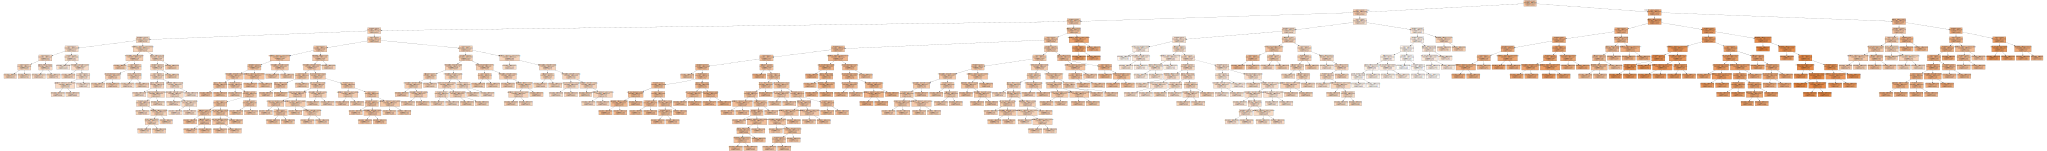

In [229]:
# 최종 트리 모델링
v_feature_name = df_con_train_x.columns

export_graphviz(tree_randomCV, out_file="tree_final.dot", feature_names=v_feature_name, impurity=True, filled=True)
with open("tree_final.dot")as f:
    dot_graph=f.read()
display(graphviz.Source(dot_graph))

In [71]:
# 다중 회귀 모델 최종 성능 평가
evaluate_model(tree_final, df_con_test_x, df_con_test_y)

Mean Absolute Error: 0.24
Mean Squared Error: 0.11
Root Mean Squared Error: 0.33
R-squared: 0.89
Adjusted R-squared: 0.89
Mean Absolute Percentage Error: 278.48 %
Coefficient of Determination: 0.89


# RandomForest about 'df_con'

## 기본모델

In [83]:
# 기본형
rf_uncustomized = RandomForestRegressor(random_state=1234)
rf_uncustomized.fit(df_con_train_x, df_con_train_y)
print("Score on train set:{0:.3f}".format(rf_uncustomized.score(df_con_train_x,df_con_train_y)))
print("Score on test set:{0:.3f}".format(rf_uncustomized.score(df_con_test_x,df_con_test_y)))

Score on train set:0.987
Score on test set:0.927


## randomCV 를 통한 파라미터 변경

In [186]:
# radomizedCV 를 통한 최적 파라미터 검색

from sklearn.metrics import mean_squared_error, make_scorer

param_space = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 4, 5, 6, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Instantiate the Random Forest model
rf = RandomForestRegressor()

# Define the RandomizedSearchCV object
rf_randomCV = RandomizedSearchCV(estimator=rf, param_distributions=param_space,
                               n_iter=100, cv=5, random_state=1234, n_jobs=-1,
                               scoring=make_scorer(mean_squared_error))

# Fit the RandomizedSearchCV object to the data
rf_randomCV.fit(df_con_train_x, df_con_train_y)

# Print the best hyperparameters and corresponding mean squared error
print('Best hyperparameters:', rf_randomCV.best_params_)

Best hyperparameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 3}


In [80]:
# randomizedCV 파라미터 적용 결과
rf_randomCV = RandomForestRegressor(n_estimators=100, min_samples_split=10, 
                                    min_samples_leaf=1, max_features='log2', 
                                    max_depth=3, random_state=1234)
rf_randomCV.fit(df_con_train_x, df_con_train_y)
print("Score on train set:{0:.3f}".format(rf_randomCV.score(df_con_train_x,df_con_train_y)))
print("Score on test set:{0:.3f}".format(rf_randomCV.score(df_con_test_x,df_con_test_y)))

Score on train set:0.766
Score on test set:0.778


## 파라미터 custom

In [190]:
# n_estimators 트리수 설정
train_score=[]
test_score=[]

para_n_tree = [n_tree*10 for n_tree in range(1,21)]

for v_n_estimators in para_n_tree:
    rf = RandomForestRegressor(n_estimators=v_n_estimators, random_state=1234)
    rf.fit(df_con_train_x, df_con_train_y)
    train_score.append(rf.score(df_con_train_x, df_con_train_y))
    test_score.append(rf.score(df_con_test_x, df_con_test_y))
    
df_score_n = pd.DataFrame()
df_score_n["n_estimators"] = para_n_tree
df_score_n["TrainScore"] = train_score
df_score_n["TestScore"] = test_score
df_score_n.round(3)

,n_estimators,TrainScore,TestScore
0,10,0.984,0.906
1,20,0.988,0.908
2,30,0.988,0.909
3,40,0.989,0.910
4,50,0.989,0.910
5,60,0.989,0.910
6,70,0.989,0.910
7,80,0.989,0.910
8,90,0.989,0.910
9,100,0.989,0.910


n_estimators = 120 결정

In [193]:
# min_samples_leaf 설정
train_score=[]
test_score=[]

para_leaf = [n_leaf*1 for n_leaf in range(1,21)]

for v_min_samples_leaf in para_leaf:
    rf = RandomForestRegressor(random_state=1234, n_estimators=120, min_samples_leaf=v_min_samples_leaf)
    rf.fit(df_con_train_x, df_con_train_y)
    train_score.append(rf.score(df_con_train_x, df_con_train_y))
    test_score.append(rf.score(df_con_test_x, df_con_test_y))
    
df_score_leaf = pd.DataFrame()
df_score_leaf["MinSamplesLeaf"] = para_leaf
df_score_leaf["TrainScore"] = train_score
df_score_leaf["TestScore"] = test_score
df_score_leaf.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,1,0.989,0.911
1,2,0.978,0.912
2,3,0.970,0.910
3,4,0.963,0.908
4,5,0.957,0.905
5,6,0.953,0.903
6,7,0.948,0.901
7,8,0.944,0.900
8,9,0.941,0.898
9,10,0.938,0.897


min_samples_leaf=2 결정

In [195]:
# min_samples_split 선택

train_score=[]
test_score=[]

para_split = [n_split*2 for n_split in range(1,21)]

for v_min_samples_split in para_split:
    rf = RandomForestRegressor(random_state=1234, n_estimators=120, min_samples_leaf=2, min_samples_split=v_min_samples_split)
    rf.fit(df_con_train_x, df_con_train_y)
    train_score.append(rf.score(df_con_train_x, df_con_train_y))
    test_score.append(rf.score(df_con_test_x, df_con_test_y))
    
df_score_leaf = pd.DataFrame()
df_score_leaf["MinSamplesSplit"] = para_split
df_score_leaf["TrainScore"] = train_score
df_score_leaf["TestScore"] = test_score
df_score_leaf.round(3)

,MinSamplesSplit,TrainScore,TestScore
0,2,0.978,0.912
1,4,0.978,0.912
2,6,0.974,0.911
3,8,0.970,0.911
4,10,0.967,0.910
5,12,0.964,0.909
6,14,0.961,0.908
7,16,0.959,0.908
8,18,0.956,0.907
9,20,0.954,0.906


min_samples_split=4 결정

In [196]:
# depth 설정

train_score=[]
test_score=[]

para_depth = [depth for depth in range(1,21)]

for v_max_depth in para_depth:
    rf = RandomForestRegressor(random_state=1234, n_estimators=120, min_samples_leaf=2, min_samples_split=4, max_depth=v_max_depth)
    rf.fit(df_con_train_x, df_con_train_y)
    train_score.append(rf.score(df_con_train_x, df_con_train_y))
    test_score.append(rf.score(df_con_test_x, df_con_test_y))
    
df_score_leaf = pd.DataFrame()
df_score_leaf["Depth"] = para_depth
df_score_leaf["TrainScore"] = train_score
df_score_leaf["TestScore"] = test_score
df_score_leaf.round(3)

,Depth,TrainScore,TestScore
0,1,0.525,0.520
1,2,0.712,0.690
2,3,0.806,0.786
3,4,0.863,0.832
4,5,0.898,0.861
5,6,0.918,0.877
6,7,0.933,0.888
7,8,0.946,0.897
8,9,0.955,0.902
9,10,0.962,0.905


depth=17  결정

기본 모델과 비교 했을 때 test 데이터에 대한 설명력이 소폭 증가했다.

## 최종 모델 결정 및 결과 해석

In [202]:
# 최종 모델 결정
rf_final = RandomForestRegressor(random_state=1234, n_estimators=120, min_samples_leaf=2, min_samples_split=4, max_depth=17)
rf_final.fit(df_con_train_x, df_con_train_y)

RandomForestRegressor(max_depth=17, min_samples_leaf=2, min_samples_split=4,
                      n_estimators=120, random_state=1234)

In [201]:
# 최종 모델 성능 평가 함수 출력
evaluate_model(rf_final, df_con_test_x, df_con_test_y)

Mean Absolute Error: 0.2
Mean Squared Error: 0.09
Root Mean Squared Error: 0.3
R-squared: 0.91
Adjusted R-squared: 0.91
Mean Absolute Percentage Error: 139.63 %
Coefficient of Determination: 0.91


In [206]:
# 변수 중요도 출력
df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["Importance"] = rf_final.feature_importances_

df_importance.sort_values("Importance", ascending=False, inplace=True)
df_importance.round(3)

,Feature,Importance
3,Power,0.499
5,Age,0.241
10,Brand_Price,0.145
2,Engine,0.041
9,KiloDriven_product_Age,0.017
8,Population_Density,0.012
6,Power_per_Engine,0.011
1,Mileage,0.010
0,Kilometers_Driven,0.009
7,Km_per_Rupee,0.008


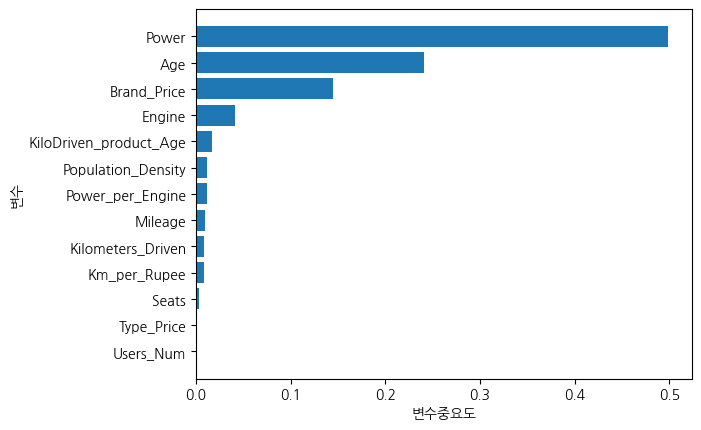

In [205]:
# 변수 중요도 시각화
df_importance.sort_values("Importance", ascending=True, inplace=True)
coordinates = range(len(df_importance))
plt.barh(y = coordinates, width=df_importance["Importance"])
plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("변수중요도")
plt.ylabel("변수")
plt.show()

# GradientBoosting about 'df_con'

## 기본모델

In [95]:
gb_uncustomized = GradientBoostingRegressor(random_state=1234)
gb_uncustomized.fit(df_con_train_x, df_con_train_y)
print("Score on train set:{0:.3f}".format(gb_uncustomized.score(df_con_train_x,df_con_train_y)))
print("Score on test set:{0:.3f}".format(gb_uncustomized.score(df_con_test_x,df_con_test_y)))

Score on train set:0.937
Score on test set:0.923


## random CV 를 통한 파라미터 변경

In [211]:
# Define the model
model = GradientBoostingRegressor(random_state=1234)

# Set the hyperparameter grid
param_grid = {
    'learning_rate': np.logspace(-4, 0, base=10, num=100),
    'max_depth': sp_randint(2, 15),
    'min_samples_leaf': sp_randint(1, 10),
    'max_features': sp_randint(1, 14),
    'n_estimators': sp_randint(100, 1000),
}

# Set up RandomizedSearchCV
gb_randomCV = RandomizedSearchCV(
    model,
    param_distributions=param_grid,
    n_iter=100,
    cv=5,
    random_state=42,
    n_jobs=-1
)

# Fit the model on the data
gb_randomCV.fit(df_con_train_x, df_con_train_y)

# Print the best hyperparameters and corresponding score
print("Best parameters: ", gb_randomCV.best_params_)

Best parameters:  {'learning_rate': 0.1291549665014884, 'max_depth': 2, 'max_features': 4, 'min_samples_leaf': 2, 'n_estimators': 971}


In [212]:
gb_randomCV = GradientBoostingRegressor(learning_rate=0.129, max_depth=2, 
                                        max_features=4, min_samples_leaf=2,
                                        n_estimators=971, random_state=1234)
gb_randomCV.fit(df_con_train_x, df_con_train_y)
print("Score on train set:{0:.3f}".format(gb_randomCV.score(df_con_train_x,df_con_train_y)))
print("Score on test set:{0:.3f}".format(gb_randomCV.score(df_con_test_x,df_con_test_y)))

Score on train set:0.965
Score on test set:0.921


## 파라미터 custom

In [215]:
# tree 수 탐색
train_score=[]
test_score=[]

para_n_tree = [n_tree*100 for n_tree in range(1,30)]

for v_n_estimators in para_n_tree:
    gb = GradientBoostingRegressor(n_estimators=v_n_estimators, random_state=1234)
    gb.fit(df_con_train_x, df_con_train_y)
    train_score.append(gb.score(df_con_train_x, df_con_train_y))
    test_score.append(gb.score(df_con_test_x, df_con_test_y))
    
df_score_n = pd.DataFrame()
df_score_n["n_estimators"] = para_n_tree
df_score_n["TrainScore"] = train_score
df_score_n["TestScore"] = test_score
df_score_n.round(3)

,n_estimators,TrainScore,TestScore
0,100,0.945,0.906
1,200,0.958,0.915
2,300,0.966,0.920
3,400,0.971,0.923
4,500,0.974,0.924
5,600,0.977,0.926
6,700,0.979,0.926
7,800,0.981,0.926
8,900,0.983,0.927
9,1000,0.984,0.927


n_estimators=900 결정

In [216]:
# MinSamplesLeaf 수 탐색
train_score=[]
test_score=[]

para_leaf = [n_leaf*1 for n_leaf in range(1,10)]

for v_min_samples_leaf in para_leaf:
    gb = GradientBoostingRegressor(random_state=1234, n_estimators=900, min_samples_leaf=v_min_samples_leaf)
    gb.fit(df_con_train_x, df_con_train_y)
    train_score.append(gb.score(df_con_train_x, df_con_train_y))
    test_score.append(gb.score(df_con_test_x, df_con_test_y))
    
df_score_leaf = pd.DataFrame()
df_score_leaf["MinSamplesLeaf"] = para_leaf
df_score_leaf["TrainScore"] = train_score
df_score_leaf["TestScore"] = test_score
df_score_leaf.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,1,0.983,0.927
1,2,0.982,0.925
2,3,0.981,0.926
3,4,0.980,0.925
4,5,0.980,0.926
5,6,0.979,0.925
6,7,0.979,0.928
7,8,0.979,0.927
8,9,0.978,0.927


min_samples_leaf=7 결정

In [218]:
# MinSamplesSplit 수 탐색
train_score=[]
test_score=[]

para_split = [n_split*2 for n_split in range(1,20)]

for v_min_samples_split in para_split:
    gb = GradientBoostingRegressor(random_state=1234, n_estimators=900, min_samples_leaf=7, min_samples_split=v_min_samples_split)
    gb.fit(df_con_train_x, df_con_train_y)
    train_score.append(gb.score(df_con_train_x, df_con_train_y))
    test_score.append(gb.score(df_con_test_x, df_con_test_y))
    
df_score_leaf = pd.DataFrame()
df_score_leaf["MinSamplesSplit"] = para_split
df_score_leaf["TrainScore"] = train_score
df_score_leaf["TestScore"] = test_score
df_score_leaf.round(3)

,MinSamplesSplit,TrainScore,TestScore
0,2,0.979,0.928
1,4,0.979,0.928
2,6,0.979,0.928
3,8,0.979,0.928
4,10,0.979,0.928
5,12,0.979,0.928
6,14,0.979,0.928
7,16,0.979,0.927
8,18,0.978,0.927
9,20,0.978,0.927


min_samples_split=12 결정

In [219]:
# depth 탐색
train_score=[]
test_score=[]

para_depth = [depth for depth in range(1,20)]

for v_max_depth in para_depth:
    gb = GradientBoostingRegressor(random_state=1234, n_estimators=900, min_samples_leaf=7, min_samples_split=12, max_depth=v_max_depth)
    gb.fit(df_con_train_x, df_con_train_y)
    train_score.append(gb.score(df_con_train_x, df_con_train_y))
    test_score.append(gb.score(df_con_test_x, df_con_test_y))
    
df_score_leaf = pd.DataFrame()
df_score_leaf["Depth"] = para_depth
df_score_leaf["TrainScore"] = train_score
df_score_leaf["TestScore"] = test_score
df_score_leaf.round(3)

,Depth,TrainScore,TestScore
0,1,0.925,0.898
1,2,0.961,0.922
2,3,0.979,0.928
3,4,0.989,0.926
4,5,0.996,0.924
5,6,0.998,0.921
6,7,0.999,0.920
7,8,1.000,0.916
8,9,1.000,0.916
9,10,1.000,0.915


depth=3 결정

In [221]:
# learning rate 탐색
train_score=[]
test_score=[]

para_lr = [lr*0.01 for lr in range(8,20)]

for v_learning_rate in para_lr:
    gb = GradientBoostingRegressor(random_state=1234, n_estimators=900, min_samples_leaf=7, 
                                   min_samples_split=12, max_depth=3, learning_rate=v_learning_rate)
    gb.fit(df_con_train_x, df_con_train_y)
    train_score.append(gb.score(df_con_train_x, df_con_train_y))
    test_score.append(gb.score(df_con_test_x, df_con_test_y))
    
df_score_lr = pd.DataFrame()
df_score_lr["Depth"] = para_lr
df_score_lr["TrainScore"] = train_score
df_score_lr["TestScore"] = test_score
df_score_lr.round(3)

,Depth,TrainScore,TestScore
0,0.08,0.976,0.927
1,0.09,0.977,0.926
2,0.10,0.979,0.928
3,0.11,0.980,0.927
4,0.12,0.981,0.927
5,0.13,0.983,0.928
6,0.14,0.984,0.927
7,0.15,0.985,0.927
8,0.16,0.985,0.927
9,0.17,0.986,0.926


learning_rate=0.13 결정

## 최종 모델 결정 및 결과 해석

In [116]:
# 최종 모델 결정
gb_final = GradientBoostingRegressor(random_state=1234, n_estimators=900, min_samples_leaf=7, 
                                   min_samples_split=12, max_depth=3, learning_rate=0.13)
gb_final.fit(df_con_train_x, df_con_train_y)

GradientBoostingRegressor(learning_rate=0.13, min_samples_leaf=7,
                          min_samples_split=12, n_estimators=900,
                          random_state=1234)

In [117]:
# 최종 모델 성능 평가 함수 출력
evaluate_model(gb_final, df_con_test_x, df_con_test_y)

Mean Absolute Error: 0.17
Mean Squared Error: 0.06
Root Mean Squared Error: 0.25
R-squared: 0.94
Adjusted R-squared: 0.94
Mean Absolute Percentage Error: 184.04 %
Coefficient of Determination: 0.94


In [118]:
df_importance1 = pd.DataFrame()
df_importance1["Feature"] = v_feature_name
df_importance1["Importance"] = gb_final.feature_importances_

df_importance1.sort_values("Importance", ascending=False, inplace=True)
df_importance1.round(3)

,Feature,Importance
3,Power,0.416
5,Age,0.228
2,Engine,0.138
10,Brand_Price,0.107
9,KiloDriven_product_Age,0.025
11,Type_Price,0.023
8,Population_Density,0.018
6,Power_per_Engine,0.013
7,Km_per_Rupee,0.011
1,Mileage,0.009


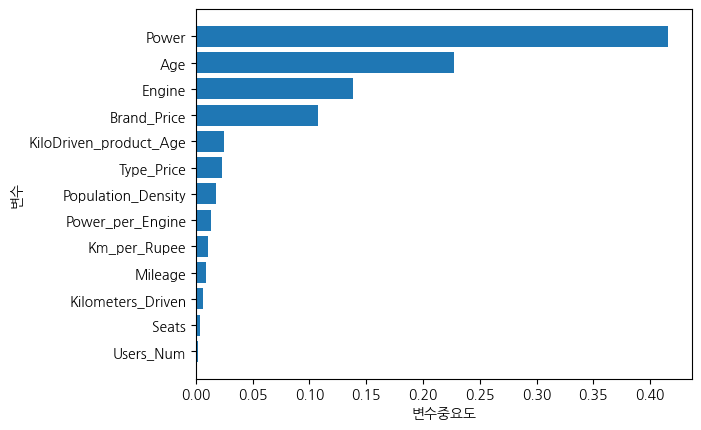

In [119]:
df_importance1.sort_values("Importance", ascending=True, inplace=True)
coordinates = range(len(df_importance1))
plt.barh(y = coordinates, width=df_importance1["Importance"])
plt.yticks(coordinates, df_importance1["Feature"])
plt.xlabel("변수중요도")
plt.ylabel("변수")
plt.show()

# DecisionTree about 'df_dummy'

## 기본 모델

In [47]:
tree_uncustomized = DecisionTreeRegressor(random_state=1234)
tree_uncustomized.fit(df_dummy_train_x, df_dummy_train_y)
print("Score on train set:{0:.3f}".format(tree_uncustomized.score(df_dummy_train_x,df_dummy_train_y)))
print("Score on test set:{0:.3f}".format(tree_uncustomized.score(df_dummy_test_x,df_dummy_test_y)))

Score on train set:1.000
Score on test set:0.844


## randomCV 로 파라미터 조정

In [46]:
# Define the hyperparameter search space
param_dist = {
    'max_depth': [2,3,4,5,7,None],
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 11),
    'max_features': ['sqrt', 'log2', None]
}

# Create a decision tree regressor object
dt = DecisionTreeRegressor()

# Create a RandomizedSearchCV object with 5-fold cross-validation
random_search = RandomizedSearchCV(estimator=dt, param_distributions=param_dist, n_iter=100, cv=5, random_state=1234)

# Fit the randomized search object to the training data
random_search.fit(df_dummy_train_x, df_dummy_train_y)

# Print the best hyperparameters found by the randomized search
print('Best hyperparameters:', random_search.best_params_)

Best hyperparameters: {'max_depth': None, 'max_features': None, 'min_samples_leaf': 8, 'min_samples_split': 6}


In [63]:
tree_randomCV2 = DecisionTreeRegressor(min_samples_leaf=8, min_samples_split=6, random_state=1234)
tree_randomCV2.fit(df_dummy_train_x, df_dummy_train_y)
print("Score on train set:{0:.3f}".format(tree_randomCV2.score(df_dummy_train_x,df_dummy_train_y)))
print("Score on test set:{0:.3f}".format(tree_randomCV2.score(df_dummy_test_x,df_dummy_test_y)))

Score on train set:0.938
Score on test set:0.888


## 최종 모델 결정 및 트리 모델링, 결과 해석

In [73]:
tree_final2 = DecisionTreeRegressor(min_samples_leaf=8, min_samples_split=6, random_state=1234)
tree_final2.fit(df_dummy_train_x, df_dummy_train_y)
print("Score on train set:{0:.3f}".format(tree_final2.score(df_dummy_train_x,df_dummy_train_y)))
print("Score on test set:{0:.3f}".format(tree_final2.score(df_dummy_test_x,df_dummy_test_y)))

Score on train set:0.938
Score on test set:0.888


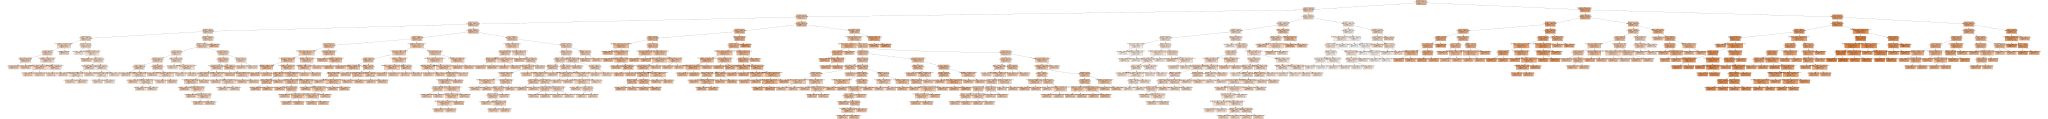

In [65]:
# 최종 트리 모델링
v_feature_name = df_dummy_train_x.columns

export_graphviz(tree_randomCV2, out_file="tree_final2.dot", feature_names=v_feature_name, impurity=True, filled=True)
with open("tree_final2.dot")as f:
    dot_graph=f.read()
display(graphviz.Source(dot_graph))

In [74]:
evaluate_model(tree_final2, df_dummy_test_x, df_dummy_test_y)

Mean Absolute Error: 0.24
Mean Squared Error: 0.11
Root Mean Squared Error: 0.33
R-squared: 0.89
Adjusted R-squared: 0.89
Mean Absolute Percentage Error: 144.93 %
Coefficient of Determination: 0.89


# RandomForest about 'df_dummy'

## 기본모델

In [84]:
# 기본형
rf_uncustomized = RandomForestRegressor(random_state=1234)
rf_uncustomized.fit(df_dummy_train_x, df_dummy_train_y)
print("Score on train set:{0:.3f}".format(rf_uncustomized.score(df_dummy_train_x,df_dummy_train_y)))
print("Score on test set:{0:.3f}".format(rf_uncustomized.score(df_dummy_test_x,df_dummy_test_y)))

Score on train set:0.988
Score on test set:0.921


## random CV 를 통한 파라미터 조정

In [78]:
# radomizedCV 를 통한 최적 파라미터 검색

from sklearn.metrics import mean_squared_error, make_scorer

param_space = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 4, 5, 6, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Instantiate the Random Forest model
rf = RandomForestRegressor()

# Define the RandomizedSearchCV object
rf_randomCV = RandomizedSearchCV(estimator=rf, param_distributions=param_space,
                               n_iter=100, cv=5, random_state=1234, n_jobs=-1,
                               scoring=make_scorer(mean_squared_error))

# Fit the RandomizedSearchCV object to the data
rf_randomCV.fit(df_dummy_train_x, df_dummy_train_y)

# Print the best hyperparameters and corresponding mean squared error
print('Best hyperparameters:', rf_randomCV.best_params_)

Best hyperparameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 3}


In [82]:
# randomizedCV 파라미터 적용 결과
rf_randomCV = RandomForestRegressor(n_estimators=200, min_samples_split=2, 
                                    min_samples_leaf=4, max_features='log2', 
                                    max_depth=3, random_state=1234)
rf_randomCV.fit(df_dummy_train_x, df_dummy_train_y)
print("Score on train set:{0:.3f}".format(rf_randomCV.score(df_dummy_train_x,df_dummy_train_y)))
print("Score on test set:{0:.3f}".format(rf_randomCV.score(df_dummy_test_x,df_dummy_test_y)))

Score on train set:0.770
Score on test set:0.766


## 파라미터 커스텀

In [85]:
# n_estimators 트리수 설정
train_score=[]
test_score=[]

para_n_tree = [n_tree*10 for n_tree in range(1,21)]

for v_n_estimators in para_n_tree:
    rf = RandomForestRegressor(n_estimators=v_n_estimators, random_state=1234)
    rf.fit(df_dummy_train_x, df_dummy_train_y)
    train_score.append(rf.score(df_dummy_train_x, df_dummy_train_y))
    test_score.append(rf.score(df_dummy_test_x, df_dummy_test_y))
    
df_score_n = pd.DataFrame()
df_score_n["n_estimators"] = para_n_tree
df_score_n["TrainScore"] = train_score
df_score_n["TestScore"] = test_score
df_score_n.round(3)

,n_estimators,TrainScore,TestScore
0,10,0.984,0.915
1,20,0.985,0.917
2,30,0.986,0.918
3,40,0.987,0.919
4,50,0.987,0.920
5,60,0.987,0.920
6,70,0.988,0.920
7,80,0.988,0.921
8,90,0.988,0.921
9,100,0.988,0.921


n_estimators=80 결정

In [86]:
# min_samples_leaf 설정
train_score=[]
test_score=[]

para_leaf = [n_leaf*1 for n_leaf in range(1,21)]

for v_min_samples_leaf in para_leaf:
    rf = RandomForestRegressor(random_state=1234, n_estimators=80, min_samples_leaf=v_min_samples_leaf)
    rf.fit(df_dummy_train_x, df_dummy_train_y)
    train_score.append(rf.score(df_dummy_train_x, df_dummy_train_y))
    test_score.append(rf.score(df_dummy_test_x, df_dummy_test_y))
    
df_score_leaf = pd.DataFrame()
df_score_leaf["MinSamplesLeaf"] = para_leaf
df_score_leaf["TrainScore"] = train_score
df_score_leaf["TestScore"] = test_score
df_score_leaf.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,1,0.988,0.921
1,2,0.977,0.921
2,3,0.967,0.920
3,4,0.960,0.917
4,5,0.953,0.916
5,6,0.948,0.914
6,7,0.944,0.912
7,8,0.940,0.910
8,9,0.936,0.909
9,10,0.933,0.908


min_samples_leaf=1 선택

In [88]:
# min_samples_split 선택

train_score=[]
test_score=[]

para_split = [n_split*2 for n_split in range(1,21)]

for v_min_samples_split in para_split:
    rf = RandomForestRegressor(random_state=1234, n_estimators=80, min_samples_leaf=1, min_samples_split=v_min_samples_split)
    rf.fit(df_dummy_train_x, df_dummy_train_y)
    train_score.append(rf.score(df_dummy_train_x, df_dummy_train_y))
    test_score.append(rf.score(df_dummy_test_x, df_dummy_test_y))
    
df_score_leaf = pd.DataFrame()
df_score_leaf["MinSamplesSplit"] = para_split
df_score_leaf["TrainScore"] = train_score
df_score_leaf["TestScore"] = test_score
df_score_leaf.round(3)

,MinSamplesSplit,TrainScore,TestScore
0,2,0.988,0.921
1,4,0.983,0.921
2,6,0.977,0.920
3,8,0.972,0.920
4,10,0.968,0.920
5,12,0.964,0.919
6,14,0.961,0.918
7,16,0.958,0.917
8,18,0.956,0.916
9,20,0.953,0.915


min_samples_split=4 결정

In [89]:
# depth 설정

train_score=[]
test_score=[]

para_depth = [depth for depth in range(1,21)]

for v_max_depth in para_depth:
    rf = RandomForestRegressor(random_state=1234, n_estimators=80, min_samples_leaf=1, min_samples_split=4, max_depth=v_max_depth)
    rf.fit(df_dummy_train_x, df_dummy_train_y)
    train_score.append(rf.score(df_dummy_train_x, df_dummy_train_y))
    test_score.append(rf.score(df_dummy_test_x, df_dummy_test_y))
    
df_score_leaf = pd.DataFrame()
df_score_leaf["Depth"] = para_depth
df_score_leaf["TrainScore"] = train_score
df_score_leaf["TestScore"] = test_score
df_score_leaf.round(3)

,Depth,TrainScore,TestScore
0,1,0.506,0.498
1,2,0.693,0.682
2,3,0.789,0.780
3,4,0.847,0.840
4,5,0.888,0.877
5,6,0.914,0.892
6,7,0.931,0.902
7,8,0.944,0.908
8,9,0.955,0.912
9,10,0.963,0.915


max_depth=17 결정

## 최종 모델 결정 및 결과 해석

In [90]:
# 최종 모델 결정
rf_final = RandomForestRegressor(random_state=1234, n_estimators=80, min_samples_leaf=1, min_samples_split=4, max_depth=17)
rf_final.fit(df_dummy_train_x, df_dummy_train_y)

RandomForestRegressor(max_depth=17, min_samples_split=4, n_estimators=80,
                      random_state=1234)

In [91]:
# 최종 모델 성능 평가 함수 출력
evaluate_model(rf_final, df_dummy_test_x, df_dummy_test_y)

Mean Absolute Error: 0.19
Mean Squared Error: 0.08
Root Mean Squared Error: 0.28
R-squared: 0.92
Adjusted R-squared: 0.92
Mean Absolute Percentage Error: 104.53 %
Coefficient of Determination: 0.92


In [92]:
# 변수 중요도 출력
df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["Importance"] = rf_final.feature_importances_

df_importance.sort_values("Importance", ascending=False, inplace=True)
df_importance.round(3)

,Feature,Importance
3,Power,0.576
5,Age,0.227
10,Brand_Price,0.071
2,Engine,0.040
9,KiloDriven_product_Age,0.023
8,Population_Density,0.013
6,Power_per_Engine,0.012
7,Km_per_Rupee,0.011
1,Mileage,0.010
0,Kilometers_Driven,0.010


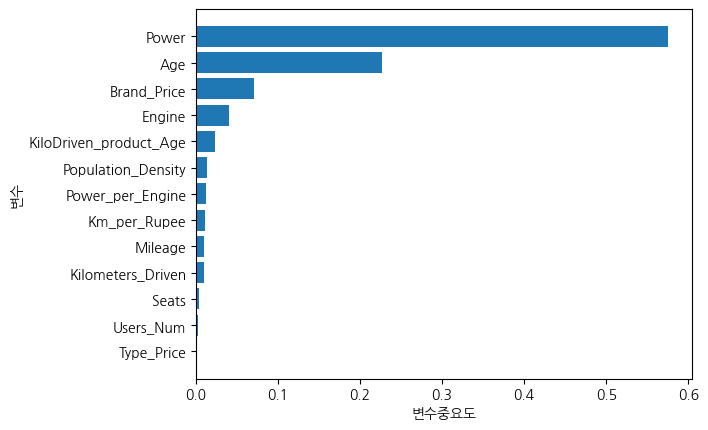

In [93]:
# 변수 중요도 시각화
df_importance.sort_values("Importance", ascending=True, inplace=True)
coordinates = range(len(df_importance))
plt.barh(y = coordinates, width=df_importance["Importance"])
plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("변수중요도")
plt.ylabel("변수")
plt.show()

# GradientBoosting about 'df_dummy'

## 기본 모델

In [96]:
gb_uncustomized = GradientBoostingRegressor(random_state=1234)
gb_uncustomized.fit(df_dummy_train_x, df_dummy_train_y)
print("Score on train set:{0:.3f}".format(gb_uncustomized.score(df_dummy_train_x,df_dummy_train_y)))
print("Score on test set:{0:.3f}".format(gb_uncustomized.score(df_dummy_test_x,df_dummy_test_y)))

Score on train set:0.942
Score on test set:0.915


## random CV 를 통한 파라미터 조정

In [99]:
# Define the model
model = GradientBoostingRegressor(random_state=1234)

# Set the hyperparameter grid
param_grid = {
    'learning_rate': np.logspace(-4, 0, base=10, num=100),
    'max_depth': sp_randint(2, 15),
    'min_samples_leaf': sp_randint(1, 10),
    'max_features': sp_randint(1, 14),
    'n_estimators': sp_randint(100, 1000),
}

# Set up RandomizedSearchCV
gb_randomCV = RandomizedSearchCV(
    model,
    param_distributions=param_grid,
    n_iter=100,
    cv=5,
    random_state=42,
    n_jobs=-1
)

# Fit the model on the data
gb_randomCV.fit(df_dummy_train_x, df_dummy_train_y)

# Print the best hyperparameters and corresponding score
print("Best parameters: ", gb_randomCV.best_params_)

Best parameters:  {'learning_rate': 0.022051307399030457, 'max_depth': 5, 'max_features': 3, 'min_samples_leaf': 3, 'n_estimators': 610}


In [100]:
gb_randomCV = GradientBoostingRegressor(learning_rate=0.022, max_depth=5, 
                                        max_features=3, min_samples_leaf=3,
                                        n_estimators=610, random_state=1234)
gb_randomCV.fit(df_dummy_train_x, df_dummy_train_y)
print("Score on train set:{0:.3f}".format(gb_randomCV.score(df_dummy_train_x,df_dummy_train_y)))
print("Score on test set:{0:.3f}".format(gb_randomCV.score(df_dummy_test_x,df_dummy_test_y)))

Score on train set:0.968
Score on test set:0.933


## 파라미터 커스텀

In [101]:
# tree 수 탐색
train_score=[]
test_score=[]

para_n_tree = [n_tree*100 for n_tree in range(1,30)]

for v_n_estimators in para_n_tree:
    gb = GradientBoostingRegressor(n_estimators=v_n_estimators, random_state=1234)
    gb.fit(df_dummy_train_x, df_dummy_train_y)
    train_score.append(gb.score(df_dummy_train_x, df_dummy_train_y))
    test_score.append(gb.score(df_dummy_test_x, df_dummy_test_y))
    
df_score_n = pd.DataFrame()
df_score_n["n_estimators"] = para_n_tree
df_score_n["TrainScore"] = train_score
df_score_n["TestScore"] = test_score
df_score_n.round(3)

,n_estimators,TrainScore,TestScore
0,100,0.942,0.915
1,200,0.956,0.920
2,300,0.964,0.922
3,400,0.969,0.924
4,500,0.973,0.925
5,600,0.976,0.926
6,700,0.978,0.926
7,800,0.980,0.927
8,900,0.982,0.926
9,1000,0.983,0.926


n_estimators=800 결정

In [102]:
# MinSamplesLeaf 수 탐색
train_score=[]
test_score=[]

para_leaf = [n_leaf*1 for n_leaf in range(1,10)]

for v_min_samples_leaf in para_leaf:
    gb = GradientBoostingRegressor(random_state=1234, n_estimators=800, min_samples_leaf=v_min_samples_leaf)
    gb.fit(df_dummy_train_x, df_dummy_train_y)
    train_score.append(gb.score(df_dummy_train_x, df_dummy_train_y))
    test_score.append(gb.score(df_dummy_test_x, df_dummy_test_y))
    
df_score_leaf = pd.DataFrame()
df_score_leaf["MinSamplesLeaf"] = para_leaf
df_score_leaf["TrainScore"] = train_score
df_score_leaf["TestScore"] = test_score
df_score_leaf.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,1,0.980,0.927
1,2,0.979,0.929
2,3,0.978,0.931
3,4,0.978,0.930
4,5,0.977,0.930
5,6,0.976,0.931
6,7,0.976,0.931
7,8,0.975,0.932
8,9,0.974,0.931


min_samples_leaf=8 결정

In [103]:
# MinSamplesSplit 수 탐색
train_score=[]
test_score=[]

para_split = [n_split*2 for n_split in range(1,20)]

for v_min_samples_split in para_split:
    gb = GradientBoostingRegressor(random_state=1234, n_estimators=800, min_samples_leaf=8, min_samples_split=v_min_samples_split)
    gb.fit(df_dummy_train_x, df_dummy_train_y)
    train_score.append(gb.score(df_dummy_train_x, df_dummy_train_y))
    test_score.append(gb.score(df_dummy_test_x, df_dummy_test_y))
    
df_score_leaf = pd.DataFrame()
df_score_leaf["MinSamplesSplit"] = para_split
df_score_leaf["TrainScore"] = train_score
df_score_leaf["TestScore"] = test_score
df_score_leaf.round(3)

,MinSamplesSplit,TrainScore,TestScore
0,2,0.975,0.932
1,4,0.975,0.932
2,6,0.975,0.932
3,8,0.975,0.932
4,10,0.975,0.932
5,12,0.975,0.932
6,14,0.975,0.932
7,16,0.975,0.932
8,18,0.974,0.933
9,20,0.974,0.933


min_samples_split=18 결정

In [104]:
# depth 탐색
train_score=[]
test_score=[]

para_depth = [depth for depth in range(1,20)]

for v_max_depth in para_depth:
    gb = GradientBoostingRegressor(random_state=1234, n_estimators=800, min_samples_leaf=8, min_samples_split=18, max_depth=v_max_depth)
    gb.fit(df_dummy_train_x, df_dummy_train_y)
    train_score.append(gb.score(df_dummy_train_x, df_dummy_train_y))
    test_score.append(gb.score(df_dummy_test_x, df_dummy_test_y))
    
df_score_leaf = pd.DataFrame()
df_score_leaf["Depth"] = para_depth
df_score_leaf["TrainScore"] = train_score
df_score_leaf["TestScore"] = test_score
df_score_leaf.round(3)

,Depth,TrainScore,TestScore
0,1,0.917,0.908
1,2,0.956,0.927
2,3,0.974,0.933
3,4,0.985,0.933
4,5,0.992,0.932
5,6,0.996,0.931
6,7,0.998,0.928
7,8,0.999,0.927
8,9,0.999,0.926
9,10,1.000,0.924


max_depth=4 결정

In [108]:
# learning rate 탐색
train_score=[]
test_score=[]

para_lr = [lr*0.01 for lr in range(4,12)]

for v_learning_rate in para_lr:
    gb = GradientBoostingRegressor(random_state=1234, n_estimators=800, min_samples_leaf=8, 
                                   min_samples_split=18, max_depth=4, learning_rate=v_learning_rate)
    gb.fit(df_dummy_train_x, df_dummy_train_y)
    train_score.append(gb.score(df_dummy_train_x, df_dummy_train_y))
    test_score.append(gb.score(df_dummy_test_x, df_dummy_test_y))
    
df_score_lr = pd.DataFrame()
df_score_lr["learning_rate"] = para_lr
df_score_lr["TrainScore"] = train_score
df_score_lr["TestScore"] = test_score
df_score_lr.round(3)

,learning_rate,TrainScore,TestScore
0,0.04,0.969,0.933
1,0.05,0.973,0.934
2,0.06,0.977,0.933
3,0.07,0.981,0.934
4,0.08,0.982,0.934
5,0.09,0.984,0.933
6,0.10,0.985,0.933
7,0.11,0.987,0.932


learning_rate=0.07 결정

## 최종 모델 결정 및 결과 해석

In [120]:
# 최종 모델 결정
gb_final = GradientBoostingRegressor(random_state=1234, n_estimators=800, min_samples_leaf=8, 
                                   min_samples_split=18, max_depth=4, learning_rate=0.07)
gb_final.fit(df_dummy_train_x, df_dummy_train_y)

GradientBoostingRegressor(learning_rate=0.07, max_depth=4, min_samples_leaf=8,
                          min_samples_split=18, n_estimators=800,
                          random_state=1234)

In [121]:
# 최종 모델 성능 평가 함수 출력
evaluate_model(gb_final, df_dummy_test_x, df_dummy_test_y)

Mean Absolute Error: 0.17
Mean Squared Error: 0.07
Root Mean Squared Error: 0.26
R-squared: 0.93
Adjusted R-squared: 0.93
Mean Absolute Percentage Error: 108.5 %
Coefficient of Determination: 0.93


In [122]:
df_importance2 = pd.DataFrame()
df_importance2["Feature"] = v_feature_name
df_importance2["Importance"] = gb_final.feature_importances_

df_importance2.sort_values("Importance", ascending=False, inplace=True)
df_importance2.round(3)

,Feature,Importance
3,Power,0.460
5,Age,0.222
10,Brand_Price,0.113
2,Engine,0.106
9,KiloDriven_product_Age,0.025
11,Type_Price,0.018
8,Population_Density,0.016
7,Km_per_Rupee,0.010
6,Power_per_Engine,0.010
1,Mileage,0.007


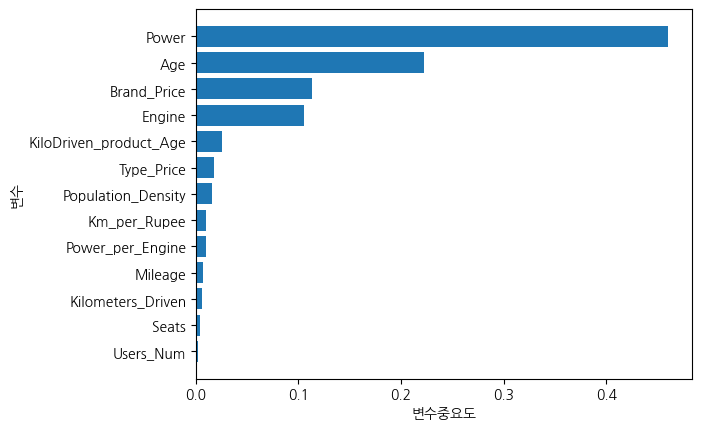

In [123]:
df_importance2.sort_values("Importance", ascending=True, inplace=True)
coordinates = range(len(df_importance2))
plt.barh(y = coordinates, width=df_importance2["Importance"])
plt.yticks(coordinates, df_importance2["Feature"])
plt.xlabel("변수중요도")
plt.ylabel("변수")
plt.show()

# 데이터프레임별 모델별 최종 성능 비교

- r2_score 기준으로 비교하도록 하겠다.

gb(df_dummy): 0.93  
rf(df_dummy): 0.92  
dt(df_dummy): 0.89  
gb(df_con): 0.94  
rf(df_con): 0.91  
dt(df_con): 0.89  
다중회귀(df_con): 0.87  